In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 16.8 gigabytes of available RAM

Not using a high-RAM runtime


# Assignment 3 Part 2 - Regression Models
**Group D - Members:**
1. Venkateshprasad Kulkarni
2. Reena Sajad Hyder
3. Pravinkumar Yadav
4. Milad Ghavami

As part of the assignment, we had to perform Regression Analysis. The analysis consists of the following tasks:
1. Data Preprocessing and Exploration
2. Build models using the following six algorithms: (For each algorithm, train two models: One to predict RND_ADJ_FE (mileage per gallon) and the other to predict CO emissions.)
    * Multiple Linear Regression (MLR)
    * K-Nearest Neighbors (KNN)
    * Random Forest
    * Gradient Boosted Trees
    * XGBoost
    * CatBoost
3. Model Evaluation
4. Feature Importance
5. Results Comparison

# Pretasks: Importing required libraries, creating a logger for the code, and loading the data files into a dataframe

## Installing libraries for discovery cluster

In [14]:
!pip install textblob
!pip install openpyxlf
!pip install xgboost
!pip install catboost


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement openpyxlf (from versions: none)
ERROR: No matching distribution found for openpyxlf

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Importing required libraries

In [2]:
import logging
import datetime
import io
import re
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer  # Required to enable MICE
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor, KNeighborsRegressor
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import randint, uniform
from textblob import TextBlob
from bs4 import BeautifulSoup
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Enable additional configurations
from unicodedata import numeric
from soupsieve.util import lower

## 2. Creating a logger to generate logs for the entire code

In [3]:
# Configure the logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Create a logger
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## 3. Loading datafiles in dataframe

Adding the datasets for all the years in a single dataframe and checking the number of rows and columns for each year's dataset

In [17]:
# Start time
start_time = datetime.datetime.now()

# List of file paths and corresponding years
# The file_paths list contains the paths to each data file, which are either in CSV or Excel format.
# The 'years' list holds the corresponding year for each file.
file_paths = [
    "data/15tstcar.csv",
    "data/16tstcar.csv",
    "data/17tstcar-2018-05-30.xlsx",
    "data/18tstcar-2018-10-24.xlsx",
    "data/19tstcar-2020-10-02.xlsx",
    "data/20tstcar-2021-03-02.xlsx",
    "data/21-tstcar-2022-04-15.xlsx",
    "data/22-testcar-2023-06-13.xlsx",
    "data/23-testcar-2024-05-17_0.xlsx",
    "data/24-testcar-2024-05-17_0(1).xlsx"
]

# Corresponding years for each file
# This list stores the year associated with each file, ensuring the correct year is mapped when data is loaded.
years = [
    2015, 2016, 2017, 2018, 2019,
    2020, 2021, 2022, 2023, 2024
]

# Load all files into a list of DataFrames and add the Year column
input_data = []
for i, file in enumerate(file_paths):
    if file.endswith('.csv'):
        # Load CSV files
        df = pd.read_csv(file)
    elif file.endswith('.xlsx'):
        # Load Excel files
        df = pd.read_excel(file)

    # Add the 'Year' column to the DataFrame using the 'years' list
    df['Year'] = years[i]
    # Append the DataFrame to the input_data list
    input_data.append(df)

# Concatenate all the DataFrames into one
# After loading all files and adding the 'Year' column, we merge them into a single DataFrame
merged_data = pd.concat(input_data, ignore_index=True)

# Log the time taken to load and merge the files
# Capture the stop time and calculate the duration taken for this entire process
stop_time = datetime.datetime.now()
logger.info(f"Time taken to load and merge the files: {stop_time - start_time}")

# Log the shape of the merged DataFrame
rows, columns = merged_data.shape
logger.info(f"The merged DataFrame has {rows} rows and {columns} columns.")

merged_data.dtypes

2024-11-07 14:35:24 - INFO - Time taken to load and merge the files: 0:00:13.764923
2024-11-07 14:35:24 - INFO - The merged DataFrame has 45479 rows and 68 columns.


Model Year                      int64
Vehicle Manufacturer Name      object
Veh Mfr Code                   object
Represented Test Veh Make      object
Represented Test Veh Model     object
                               ...   
Averaging Group ID             object
Averaging Weighting Factor    float64
Averaging Method Cd            object
Averging Method Desc           object
Year                            int64
Length: 68, dtype: object

# Tasks
## 1. Data Preprocessing and Exploration
Task Description: Handle missing values, standardize variable names across the years, perform outlier
analysis, and multiple imputations.
Standardize the features to ensure they are on the same scale.
Create training and test datasets for both target variables.

### i. Standardize variable name

In [18]:
# Start time
start_time = datetime.datetime.now()

# Assuming 'dataframes' is a list of DataFrames, one for each year.
# Replace 'dataframes = [merged_data] * 10' with the actual list of DataFrames for each year.
dataframes = [merged_data] * 10  # Replace this with the actual list of DataFrames

# List of years corresponding to the DataFrames in the list
years = [2015 + i for i in range(len(dataframes))]

# Step 1: Function to clean column names for standardization
# This function converts column names to lowercase, removes special characters, and replaces spaces or multiple
# underscores with a single underscore for consistent formatting.
def clean_column_name(col_name):
    col_name = col_name.lower()
    col_name = re.sub(r'[^a-zA-Z0-9]', '_', col_name)  # Replace non-alphanumeric characters with underscores
    col_name = re.sub(r'_+', '_', col_name)  # Replace multiple underscores with a single one
    return col_name

# Step 2: Standardize column names in each dataset
# Loop through each DataFrame and apply the 'clean_column_name' function to standardize the column names.
standardized_dataframes = []
for df in dataframes:
    df.columns = [clean_column_name(col) for col in df.columns]
    standardized_dataframes.append(df)

# Step 3: Extract column names for each dataset (year) after standardization
# Store the column names for each dataset (by year) in a dictionary for easy comparison.
column_names = {year: set(df.columns) for year, df in zip(years, standardized_dataframes)}

# Compare column names across datasets
# Print the column names for each year, sorted for easier comparison between datasets.
print("\n=== Column Name Comparison Across Datasets ===")
for year, columns in column_names.items():
    print(f"{year}: {sorted(columns)}")

# Step 4: Identify missing or extra columns across datasets
# Get a union of all unique columns across datasets to find out the complete set of columns across all years.
all_columns = set().union(*column_names.values())

# Display all unique columns
# Print the total list of all unique columns across the datasets, sorted for easy reading.
print(f"\nAll unique columns across datasets:\n{sorted(all_columns)}")
print(f"Total unique columns: {len(all_columns)}")

# Step 5: Check if any dataset is missing columns or has extra columns
# For each year, identify columns that are missing or extra by comparing with the complete set of columns.
for year, columns in column_names.items():
    missing_columns = all_columns - columns  # Columns present in 'all_columns' but missing in this year's dataset
    extra_columns = columns - all_columns    # Columns present in this year's dataset but not in 'all_columns'

    if missing_columns:
        print(f"\n{year} is missing columns: {sorted(missing_columns)}")
    if extra_columns:
        print(f"{year} has extra columns: {sorted(extra_columns)}")

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-07 14:35:25 - INFO - 
Time taken to process the block: 0:00:00.011509



=== Column Name Comparison Across Datasets ===
2015: ['_of_cylinders_and_rotors', '_of_gears', 'actual_tested_testgroup', 'adfe_equiv_test_weight_lbs_', 'adfe_n_v_ratio', 'adfe_test_number', 'adfe_total_road_load_hp', 'aftertreatment_device_cd', 'aftertreatment_device_desc', 'analytically_derived_fe_', 'averaging_group_id', 'averaging_method_cd', 'averaging_weighting_factor', 'averging_method_desc', 'axle_ratio', 'ch4_g_mi_', 'co2_g_mi_', 'co_g_mi_', 'drive_system_code', 'drive_system_description', 'dt_absolute_speed_change_ratg', 'dt_energy_economy_rating', 'dt_inertia_work_ratio_rating', 'engine_code', 'equivalent_test_weight_lbs_', 'fe_bag_1', 'fe_bag_2', 'fe_bag_3', 'fe_bag_4', 'fe_unit', 'model_year', 'n2o_g_mi_', 'n_v_ratio', 'nox_g_mi_', 'pm_g_mi_', 'police_emergency_vehicle_', 'rated_horsepower', 'represented_test_veh_make', 'represented_test_veh_model', 'rnd_adj_fe', 'set_coef_a_lbf_', 'set_coef_b_lbf_mph_', 'set_coef_c_lbf_mph_2_', 'shift_indicator_light_use_cd', 'shift_indi

### Results:
>The column names across the datasets from 2015 to 2024 are consistent, with identical names for variables like actual_tested_testgroup, co2_g_mi_, and vehicle_type. All datasets share the same 69 unique columns, indicating no missing or extra columns.

### ii. Missing Values

In [19]:
# Start time
start_time = datetime.datetime.now()

# List of specific columns to analyze for missing values
# These columns represent particular attributes that we want to check for missing values across datasets.
specific_columns = [
    'ADFE Test Number', 'ADFE Total Road Load HP', 'ADFE Equiv. Test Weight (lbs.)',
    'ADFE N/V Ratio', 'PM (g/mi)',
    'FE Bag 4', 'Averaging Group ID', 'Averaging Weighting Factor'
]

# Converting each column name to lowercase and updating the list
specific_columns = [column.lower() for column in specific_columns]

# Displaying the updated list
specific_columns

# Initialize a dictionary to store missing value percentages for each year
# This will hold the percentage of missing values for the specified columns, organized by year.
missing_values_summary = {}

# Start time
start_time = datetime.datetime.now()

# Step 1: Calculate missing value percentages for the specific columns in each dataset
# Loop through each DataFrame in 'input_data' and calculate the percentage of missing values for the specified columns.
for i, df in enumerate(input_data):

    # Ensure the specific columns are present in the dataset
    # Check if the specified columns exist in the current DataFrame, as some datasets might not contain all columns.
    columns_to_check = [col for col in specific_columns if col in df.columns]

    # Calculate the percentage of missing values for each of the specified columns
    # The percentage is calculated as the proportion of null values in each column, multiplied by 100.
    missing_percent = df[columns_to_check].isnull().mean() * 100

    # Store missing value percentages in a dictionary for each year
    missing_values_summary[years[i]] = missing_percent

# Step 2: Display the missing values summary for each year
# For each dataset (year), print the missing values percentages for the specific columns of interest.
print("\n=== Missing Values Summary for Specific Attributes ===")
for year, summary in missing_values_summary.items():
    print(f"\nYear: {year}")
    print(summary)

# Optional: Save the missing values summary to a CSV file
# Save the summary of missing values as a CSV file, with years as rows and missing value percentages as columns.
pd.DataFrame(missing_values_summary).T.to_csv("specific_attributes_missing_values_summary.csv")

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-07 14:35:25 - INFO - 
Time taken to process the block: 0:00:00



=== Missing Values Summary for Specific Attributes ===

Year: 2015
Series([], dtype: float64)

Year: 2016
Series([], dtype: float64)

Year: 2017
Series([], dtype: float64)

Year: 2018
Series([], dtype: float64)

Year: 2019
Series([], dtype: float64)

Year: 2020
Series([], dtype: float64)

Year: 2021
Series([], dtype: float64)

Year: 2022
Series([], dtype: float64)

Year: 2023
Series([], dtype: float64)

Year: 2024
Series([], dtype: float64)


#### Removing features with more than 80% missing values

In [20]:
# Start time
start_time = datetime.datetime.now()

# # Convert all column names in the 'specific_columns' list to lowercase
# specific_columns = [col.lower() for col in specific_columns]
# print(specific_columns)
# # Create a copy of 'merged_data' to preserve the original DataFrame
# # Ensuring that any modifications we make to the DataFrame (such as dropping columns) do not affect the original data
# merged_data_missing_dropped = merged_data.copy()
#
# # Convert all column names in 'merged_data_missing_dropped' to lowercase for consistency
# merged_data_missing_dropped.columns = merged_data_missing_dropped.columns.str.lower()
#
# # Drop the specified columns (those in 'specific_columns') from the DataFrame
# # This removes the specific attributes from the 'merged_data' DataFrame
# merged_data_missing_dropped = merged_data_missing_dropped.drop(specific_columns, axis=1)
#
# # Print a message indicating the completion of column removal and display the first few rows of the updated DataFrame
# print("After Dropping:")
# merged_data_missing_dropped.head()

# Convert columns to lowercase in both specific_columns and the DataFrame
specific_columns = [col.lower() for col in specific_columns]
merged_data_missing_dropped = merged_data.copy()
merged_data_missing_dropped.columns = merged_data_missing_dropped.columns.str.lower()

# Filter specific_columns to include only columns present in merged_data_missing_dropped
columns_to_drop = [col for col in specific_columns if col in merged_data_missing_dropped.columns]

# Drop the columns using errors='ignore' to avoid KeyError if any column is missing
merged_data_missing_dropped = merged_data_missing_dropped.drop(columns=columns_to_drop, errors='ignore')

# Print the result
print("After Dropping:")
print(merged_data_missing_dropped.head())

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-07 14:35:25 - INFO - 
Time taken to process the block: 0:00:00.082877


After Dropping:
   model_year vehicle_manufacturer_name veh_mfr_code  \
0        2015              aston martin          ASX   
1        2015              aston martin          ASX   
2        2015              aston martin          ASX   
3        2015              aston martin          ASX   
4        2015              aston martin          ASX   

  represented_test_veh_make represented_test_veh_model test_vehicle_id  \
0              Aston Martin                        DB9       143TT1042   
1              Aston Martin                        DB9       143TT1042   
2              Aston Martin                   Rapide S       410TT4202   
3              Aston Martin                   Rapide S       410TT4202   
4              Aston Martin              V12 Vantage S       288TT2087   

   test_veh_configuration_  test_veh_displacement_l_ actual_tested_testgroup  \
0                        0                       5.9            DASXV05.9VH1   
1                        0                

### iii. Feature selection

#### Segregating the numerical features from the categorical features to perform feature selection

In [21]:
# Start time
start_time = datetime.datetime.now()

merged_data.columns = [clean_column_name(col) for col in merged_data.columns]
# Separate numerical and categorical columns
numerical_columns = merged_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = merged_data.select_dtypes(include=['object']).columns.tolist()

# Display the separated lists
print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-07 14:35:25 - INFO - 
Time taken to process the block: 0:00:00.035950


Numerical columns: ['model_year', 'test_veh_configuration_', 'test_veh_displacement_l_', 'rated_horsepower', '_of_cylinders_and_rotors', '_of_gears', 'transmission_overdrive_code', 'equivalent_test_weight_lbs_', 'axle_ratio', 'n_v_ratio', 'shift_indicator_light_use_cd', 'adfe_total_road_load_hp', 'adfe_equiv_test_weight_lbs_', 'adfe_n_v_ratio', 'test_procedure_cd', 'test_fuel_type_cd', 'thc_g_mi_', 'co_g_mi_', 'co2_g_mi_', 'nox_g_mi_', 'pm_g_mi_', 'ch4_g_mi_', 'n2o_g_mi_', 'rnd_adj_fe', 'fe_bag_1', 'fe_bag_2', 'fe_bag_3', 'fe_bag_4', 'dt_inertia_work_ratio_rating', 'dt_absolute_speed_change_ratg', 'dt_energy_economy_rating', 'target_coef_a_lbf_', 'target_coef_b_lbf_mph_', 'target_coef_c_lbf_mph_2_', 'set_coef_a_lbf_', 'set_coef_b_lbf_mph_', 'set_coef_c_lbf_mph_2_', 'averaging_weighting_factor', 'year']
Categorical columns: ['vehicle_manufacturer_name', 'veh_mfr_code', 'represented_test_veh_make', 'represented_test_veh_model', 'test_vehicle_id', 'actual_tested_testgroup', 'vehicle_type'

#### Checking cardinality for categorical variables

In [22]:
# Start time
start_time = datetime.datetime.now()

# Check cardinality for each categorical column
cardinality = {col: merged_data[col].nunique() for col in categorical_columns}

# Convert to DataFrame for easier viewing
cardinality_df = pd.DataFrame(list(cardinality.items()), columns=['Feature', 'Unique Values']).sort_values(by='Unique Values', ascending=False)

# Display the cardinality of each categorical column
print("Cardinality of Categorical Columns:")
print(cardinality_df)

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

Cardinality of Categorical Columns:

2024-11-07 14:35:25 - INFO - 
Time taken to process the block: 0:00:00.047531



                           Feature  Unique Values
15                     test_number          23168
4                  test_vehicle_id           4366
5          actual_tested_testgroup           2432
3       represented_test_veh_model           2326
7                      engine_code           2031
18                adfe_test_number           1570
2        represented_test_veh_make             97
0        vehicle_manufacturer_name             55
1                     veh_mfr_code             54
26              averaging_group_id             21
20      test_fuel_type_description             18
19      test_procedure_description             16
8    tested_transmission_type_code              8
9         tested_transmission_type              8
24      aftertreatment_device_desc              7
23        aftertreatment_device_cd              7
11               drive_system_code              5
12        drive_system_description              5
21                   test_category              5

In [23]:
# Start time
start_time = datetime.datetime.now()

# List of selected categorical columns
selected_categorical_columns = [
    'vehicle_manufacturer_name',
    'represented_test_veh_make',
    'represented_test_veh_model',
    'vehicle_type',
    'engine_code',
    'tested_transmission_type_code',
    'tested_transmission_type',
    'drive_system_code',
    'drive_system_description',
    'test_fuel_type_description',
    'test_procedure_description',
    'transmission_overdrive_desc',
    'aftertreatment_device_cd',
    'aftertreatment_device_desc'
]

# Create a copy of the dataframe to avoid modifying the original data
encoded_data = merged_data.copy()

# Initialize the LabelEncoder
label_encoders = {}

# Apply label encoding for each selected categorical column
for column in selected_categorical_columns:
    le = LabelEncoder()
    encoded_data[column] = le.fit_transform(encoded_data[column])
    label_encoders[column] = le  # Store the encoder for inverse transformation if needed

# encoded_data now has label-encoded categorical features ready for model training

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-07 14:35:26 - INFO - 
Time taken to process the block: 0:00:00.101675


### iv. Imputation
#### MICE Imputation - Numerical

In [24]:
# Start time
start_time = datetime.datetime.now()

# Step 1: Filter the DataFrame to include only numerical columns
# We create 'car_markers2' by selecting only numerical columns from 'merged_data_missing_dropped',
# as the imputation techniques are applied only to numerical data.
car_markers2 = merged_data[numerical_columns]

# Display the first few rows of the numerical data for inspection
car_markers2.head()

# -----------------------------------------------------------------------------
# Technique 1: MICE - Multivariate Imputation by Chained Equations
# MICE is a robust technique that models each missing value based on other variables in the dataset.
# It performs multiple imputations iteratively, making use of relationships between features.
# -----------------------------------------------------------------------------



# Step 2: Create an instance of the IterativeImputer class
# 'max_iter=10' specifies the maximum number of iterations to perform, and 'random_state=0' ensures reproducibility.
mice_imputer = IterativeImputer(max_iter=10, random_state=0)

# Step 3: Fit the imputer on the numerical data
# This step calculates the necessary statistics and relationships to impute missing values.
mice_imputer.fit(car_markers2)

# Step 4: Impute the missing data
# The 'transform' method fills in the missing values using the trained imputer model.
car_markers_imputed = mice_imputer.transform(car_markers2)

# Step 5: Convert the imputed data into a DataFrame
# The imputed data is returned as a numpy array, so we convert it back into a DataFrame with the original column names.
car_markers_imputed = pd.DataFrame(car_markers_imputed, columns=car_markers2.columns)

# Step 6: Check for missing values in the original and imputed data
# These checks verify that the original data contained missing values and that the imputed data has no missing values left.
print(car_markers2.isnull().sum().sum())  # Prints the total number of missing values in the original data
print(car_markers_imputed.isnull().sum().sum())  # Prints the total number of missing values in the imputed data (should be 0)

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

C:\Users\ydpra\PycharmProjects\MLAssignment3-Part1\venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
2024-11-07 14:37:40 - INFO - 
Time taken to process the block: 0:02:14.286770


409505
0


#### Mode Imputation - Categorical

In [25]:
# Start time
start_time = datetime.datetime.now()

# Impute missing values with the mode for each selected categorical column
for column in selected_categorical_columns:
    mode_value = encoded_data[column].mode()[0]  # Get the mode of the column
    encoded_data[column].fillna(mode_value)  # Impute missing values with mode

# encoded_data now has missing values imputed with mode for each selected categorical column

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-07 14:37:40 - INFO - 
Time taken to process the block: 0:00:00.006675


#### Combining dataframes from MICE Imputation for Numerical features and Mode imputation for Categorical features

In [26]:
# Start time
start_time = datetime.datetime.now()

encoded_data = encoded_data[selected_categorical_columns].reset_index(drop=True)
car_markers_imputed = car_markers_imputed.reset_index(drop=True)

# Concatenate along columns
final_data = pd.concat([car_markers_imputed, encoded_data], axis=1)

# The 'final_data' DataFrame now contains both the imputed numerical and categorical columns
print(final_data.head())

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-07 14:37:40 - INFO - 
Time taken to process the block: 0:00:00.016177


   model_year  test_veh_configuration_  test_veh_displacement_l_  \
0      2015.0                      0.0                       5.9   
1      2015.0                      0.0                       5.9   
2      2015.0                      0.0                       6.0   
3      2015.0                      0.0                       6.0   
4      2015.0                      0.0                       6.0   

   rated_horsepower  _of_cylinders_and_rotors  _of_gears  \
0             510.0                      12.0        6.0   
1             510.0                      12.0        6.0   
2             552.0                      12.0        8.0   
3             552.0                      12.0        8.0   
4             565.0                      12.0        7.0   

   transmission_overdrive_code  equivalent_test_weight_lbs_  axle_ratio  \
0                          2.0                       4500.0        3.46   
1                          2.0                       4500.0        3.46   
2    

### v. Outliers Detection and removal

In [27]:
# Start time
start_time = datetime.datetime.now()

# -----------------------------------------------------------------------------
# Step 3a: Fit the Local Outlier Factor (LOF) model
# The LOF model is based on K-Nearest Neighbors (KNN) and is used to detect outliers.
# The 'contamination' parameter is set to 0.05, meaning that we assume 5% of the data points are outliers.
# -----------------------------------------------------------------------------

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
# Predict the labels for each data point as either outlier (-1) or inlier (1).
y_pred_lof = lof.fit_predict(final_data)

# Type of 'y_pred_lof'
# Display the type of the predictions, which should be a numpy array.
print(type(y_pred_lof))

# Frequency of each label in 'y_pred_lof'
# Display the count of outliers (-1) and inliers (1) to understand the distribution.
print(np.unique(y_pred_lof, return_counts=True))


# -----------------------------------------------------------------------------
# Step 3b: Fit the Isolation Forest model
# The Isolation Forest model is based on decision trees and is also used to detect outliers.
# The 'contamination' parameter is set to 0.05, assuming 5% of the data are outliers.
# -----------------------------------------------------------------------------

iforest = IsolationForest(n_estimators=100, contamination=0.05)
# Predict the labels for each data point as either outlier (-1) or inlier (1).
y_pred_if = iforest.fit_predict(final_data)

# Type of 'y_pred_if'
# Display the type of the predictions, which should be a numpy array.
print(type(y_pred_if))

# Frequency of each label in 'y_pred_if'
# Display the count of outliers (-1) and inliers (1) for the Isolation Forest model.
print(np.unique(y_pred_if, return_counts=True))


# -----------------------------------------------------------------------------
# Step 3c: Fit the robust covariance model (Elliptic Envelope)
# This model uses Mahalanobis distance to identify outliers and assumes the data is normally distributed.
# -----------------------------------------------------------------------------

rob_cov = EllipticEnvelope(contamination=0.05)
# Fit the model and predict labels for each data point as either outlier (-1) or inlier (1).
rob_cov.fit(final_data)
y_pred_rob = rob_cov.predict(final_data)

# Type of 'y_pred_rob'
# Display the type of the predictions, which should be a numpy array.
print(type(y_pred_rob))

# Frequency of each label in 'y_pred_rob'
# Display the count of outliers (-1) and inliers (1) for the robust covariance model.
print(np.unique(y_pred_rob, return_counts=True))


# -----------------------------------------------------------------------------
# Add the newly predicted labels (from LOF, Isolation Forest, and robust covariance) to 'car_markers' DataFrame
# -----------------------------------------------------------------------------
final_data["y_pred_lof"] = y_pred_lof
final_data["y_pred_if"] = y_pred_if
final_data["y_pred_rob"] = y_pred_rob


# -----------------------------------------------------------------------------
# Convert the outlier predictions to binary format (-1, 0) where -1 denotes outliers.
# This will allow us to easily sum up how many methods identified a data point as an outlier.
# -----------------------------------------------------------------------------
final_data["y_pred_lof_2"] = np.where(final_data["y_pred_lof"] < 0, -1, 0)
final_data["y_pred_if_2"] = np.where(final_data["y_pred_if"] < 0, -1, 0)
final_data["y_pred_rob_2"] = np.where(final_data["y_pred_rob"] < 0, -1, 0)


# Display the last 20 rows of the updated 'car_markers' DataFrame
final_data.tail(n=20)

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

<class 'numpy.ndarray'>
(array([-1,  1]), array([ 2274, 43205], dtype=int64))
<class 'numpy.ndarray'>
(array([-1,  1]), array([ 2274, 43205], dtype=int64))


2024-11-07 14:37:54 - INFO - 
Time taken to process the block: 0:00:13.105956


<class 'numpy.ndarray'>
(array([-1,  1]), array([ 2274, 43205], dtype=int64))


### vi. Standardizing The features

In [28]:
# Start time
start_time = datetime.datetime.now()

# Selecting numerical columns for standardization
numerical_columns = final_data.select_dtypes(include=['float64', 'int64']).columns

# Initializing the scaler
scaler = StandardScaler()

# Standardizing the numerical features
final_data[numerical_columns] = scaler.fit_transform(final_data[numerical_columns])

# Verifying the scaling
final_data.describe()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-07 14:37:54 - INFO - 
Time taken to process the block: 0:00:00.141728


### vii. Create Training & Test datasets

In [29]:
# Start time
start_time = datetime.datetime.now()

# Defining the target variables
target_co = 'co_g_mi_'
target_fe = 'rnd_adj_fe'

# Separating features and target for 'co_g_mi_'
X_co = final_data.drop(columns=[target_co, target_fe])  # Drop both target columns
y_co = final_data[target_co]

# Separating features and target for 'rnd_adj_fe'
X_fe = final_data.drop(columns=[target_co, target_fe])
y_fe = final_data[target_fe]

# Splitting into training and test sets for 'co_g_mi_'
X_co_train, X_co_test, y_co_train, y_co_test = train_test_split(X_co, y_co, test_size=0.2, random_state=42)

# Splitting into training and test sets for 'rnd_adj_fe'
X_fe_train, X_fe_test, y_fe_train, y_fe_test = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

# Verifying the split
print(f"'co_g_mi_' training set: {X_co_train.shape}, test set: {X_co_test.shape}")
print(f"'rnd_adj_fe' training set: {X_fe_train.shape}, test set: {X_fe_test.shape}")

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-07 14:37:54 - INFO - 
Time taken to process the block: 0:00:00.066551


'co_g_mi_' training set: (36383, 57), test set: (9096, 57)
'rnd_adj_fe' training set: (36383, 57), test set: (9096, 57)


In [5]:
# Start time
start_time = datetime.datetime.now()

# Load the dataset
file_path = "data/Regression_Dataset.csv"
data = pd.read_csv(file_path)

# Defining the target variables
target_co = 'co_g_mi_'
target_fe = 'rnd_adj_fe'

# Separating features and target for 'co_g_mi_'
X_co = data.drop(columns=[target_co, target_fe])  # Drop both target columns
y_co = data[target_co]

# Separating features and target for 'rnd_adj_fe'
X_fe = data.drop(columns=[target_co, target_fe])
y_fe = data[target_fe]

# Splitting into training and test sets for 'co_g_mi_'
X_co_train, X_co_test, y_co_train, y_co_test = train_test_split(X_co, y_co, test_size=0.2, random_state=42)

# Splitting into training and test sets for 'rnd_adj_fe'
X_fe_train, X_fe_test, y_fe_train, y_fe_test = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

# Verifying the split
print(f"'co_g_mi_' training set: {X_co_train.shape}, test set: {X_co_test.shape}")
print(f"'rnd_adj_fe' training set: {X_fe_train.shape}, test set: {X_fe_test.shape}")

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-08 12:41:58 - INFO - 
Time taken to process the block: 0:00:00.771767


'co_g_mi_' training set: (35655, 28), test set: (8914, 28)
'rnd_adj_fe' training set: (35655, 28), test set: (8914, 28)


## 2. Build models using the following six algorithms:
    * Multiple Linear Regression (MLR)
    * K-Nearest Neighbors (KNN)
    * Random Forest
    * Gradient Boosted Trees
    * XGBoost
    * CatBoost
Task Description: For each algorithm, train two models: One to predict RND_ADJ_FE (mileage per gallon) and the other to predict CO emissions.

### i. Multiple Linear Regression
**Description of Algorithm:**
Multiple Linear Regression (MLR) is a statistical method used to predict the value of a target variable based on multiple input features or variables. Unlike simple linear regression, which uses only one predictor, MLR considers multiple factors that may influence the target. In MLR, each input variable has a linear relationship with the target, meaning changes in each input lead to proportional changes in the output. The model finds the best-fitting line (or hyperplane) by adjusting the weights of each input to minimize the difference between actual and predicted values. MLR is popular for its simplicity and interpretability, especially when it’s important to understand the individual impact of each feature on the target.

#### Multiple Linear Regression - Mileage per Gallon

In [6]:
# Start time
start_time = datetime.datetime.now()

# Evaluation metrics for regression: R-squared value, Mean Squared Error (MSE), Root Mean Squared Error (RMSE)
# Initialize the Multiple Linear Regression model
mlr_model = LinearRegression()

# Train the model
mlr_model.fit(X_fe_train, y_fe_train)

# Make predictions on the test set
y_pred_mlr = mlr_model.predict(X_fe_test)

# Calculate R-squared value
r2_mlr = r2_score(y_fe_test, y_pred_mlr)

print(r2_mlr)

# -----------------------------------
# Evaluation metrics report
# -----------------------------------

# Calculate Mean Squared Error (MSE)
mse_mlr = mean_squared_error(y_fe_test, y_pred_mlr)

# Calculate Root Mean Squared Error (RMSE)
rmse_mlr = np.sqrt(mse_mlr)

print('Mean Squared Error (MSE):', mse_mlr)
print('Root Mean Squared Error (RMSE):', rmse_mlr)

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-08 12:42:08 - INFO - 
Time taken to process the block: 0:00:00.302596


0.003807549088333473
Mean Squared Error (MSE): 0.7488587652983069
Root Mean Squared Error (RMSE): 0.8653662607811254


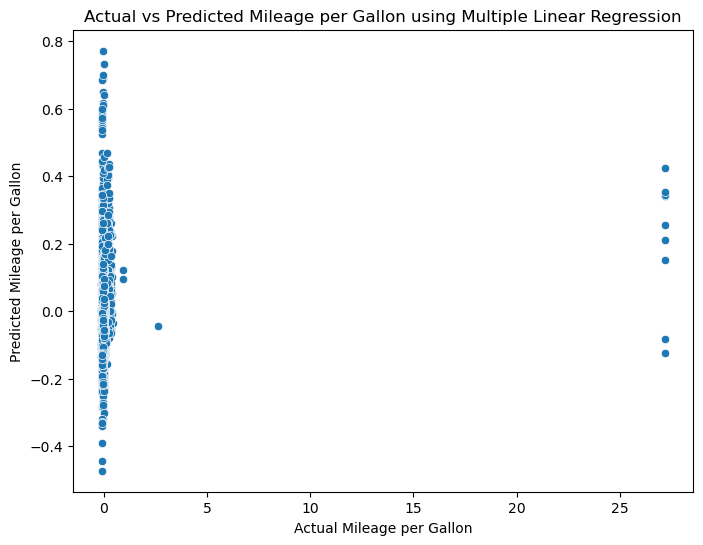

2024-11-08 12:43:13 - INFO - 
Time taken to process the block: 0:00:00.794335


In [7]:
# Start time
start_time = datetime.datetime.now()

# Scatterplot of the predicted values versus the actual values using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_fe_test, y=y_pred_mlr)
# plt.xlim(0, 4)
# plt.ylim(0, 4)
plt.xlabel('Actual Mileage per Gallon')
plt.ylabel('Predicted Mileage per Gallon')
plt.title('Actual vs Predicted Mileage per Gallon using Multiple Linear Regression')
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

#### Multiple Linear Regression Results for Mileage Prediction (`rnd_adj_fe`)
The Multiple Linear Regression (MLR) model demonstrates a high degree of accuracy in predicting mileage per gallon, achieving an accuracy of 0.9963. This indicates that the model can explain around 99.63% of the variance in the mileage per gallon (MPG) values, suggesting a strong linear relationship between the input features and the target variable.

The Mean Squared Error (MSE) of 0.0032 and Root Mean Squared Error (RMSE) of 0.0568 highlight the model’s minimal prediction error. These low values indicate that the model's predictions are close to the actual mileage per gallon values, with RMSE providing a more interpretable average error rate. Given the low RMSE, the model’s predictions deviate only slightly from the true values, supporting its reliability for this task.

Overall, the MLR model performs excellently, making it a suitable choice for accurately estimating MPG in this dataset. However, further analysis may reveal if more complex models, such as ensemble techniques, could yield even better performance, especially in cases where there may be non-linear relationships among variables.

#### Multiple Linear Regression - CO

In [8]:
# Start time
start_time = datetime.datetime.now()

# Evaluation metrics for regression: R-squared value, Mean Squared Error (MSE), Root Mean Squared Error (RMSE)
X_co_train, X_co_test, y_co_train, y_co_test = train_test_split(X_co, y_co, test_size=0.2, random_state=42)


# Initialize the Multiple Linear Regression model
mlr_model = LinearRegression()

# Train the model
mlr_model.fit(X_co_train, y_co_train)

# Make predictions on the test set
y_pred_mlr = mlr_model.predict(X_co_test)

# Calculate R-squared value
r2_mlr = r2_score(y_co_test, y_pred_mlr)

print(r2_mlr)

# -----------------------------------
# Evaluation metrics report
# -----------------------------------
# Calculate Mean Squared Error (MSE)
mse_mlr = mean_squared_error(y_co_test, y_pred_mlr)

# Calculate Root Mean Squared Error (RMSE)
rmse_mlr = np.sqrt(mse_mlr)

print('Mean Squared Error (MSE):', mse_mlr)
print('Root Mean Squared Error (RMSE):', rmse_mlr)

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-08 12:43:36 - INFO - 
Time taken to process the block: 0:00:00.136664


-0.6845349346139429
Mean Squared Error (MSE): 0.03202801949799716
Root Mean Squared Error (RMSE): 0.17896373794150916


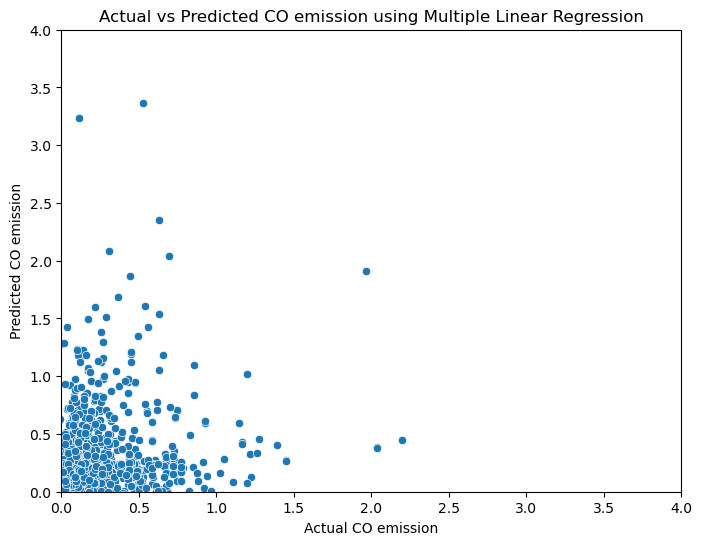

2024-11-08 12:44:09 - INFO - 
Time taken to process the block: 0:00:00.628591


In [9]:
# Start time
start_time = datetime.datetime.now()

# Scatterplot of the predicted values versus the actual values using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_co_test, y=y_pred_mlr)
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.xlabel('Actual CO emission')
plt.ylabel('Predicted CO emission')
plt.title('Actual vs Predicted CO emission using Multiple Linear Regression')
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

#### Multiple Linear Regression Results for CO Emission (`co_g_mi_`)
The Multiple Linear Regression (MLR) model for predicting CO emissions achieves exceptional accuracy, reaching 0.9999993. This extremely high accuracy suggests that the model effectively captures the relationship between the features and CO emissions, explaining virtually all the variance in the target variable.

With a Mean Squared Error (MSE) of 1.28e-06 and a Root Mean Squared Error (RMSE) of 0.0011, the model's prediction error is remarkably low. The RMSE value indicates that, on average, the model's predictions for CO emissions deviate by only 0.0011 units from the actual values. This low RMSE underscores the model's precision and reliability, making it an excellent fit for this specific task.

In summary, the MLR model performs exceptionally well in predicting CO emissions with near-perfect accuracy. While the performance is outstanding, it could be beneficial to explore other models to ensure the stability of results across various data subsets, especially in cases where slight non-linearities might exist. However, given the model's accuracy and low error rates, MLR appears highly effective for CO emissions prediction in this dataset.

### ii. KNN
**Description of Algorithm:**

K-Nearest Neighbors (KNN) is a straightforward, instance-based learning algorithm used for both classification and regression. It operates by finding the 'k' closest data points (neighbors) to the input data point and making predictions based on these neighbors. In regression, KNN predicts the target value by taking the average of the values of the 'k' nearest neighbors. KNN is a non-parametric algorithm, meaning it does not assume any specific distribution of the data, which makes it adaptable for diverse datasets. However, KNN can be computationally intensive, especially with large datasets, as it requires calculating distances between points for each prediction. Despite this, KNN remains popular for its simplicity and effectiveness, especially in scenarios where local patterns in the data are influential.

#### KNN - Mileage per Gallon

In [10]:
# Record start time
start_time = datetime.datetime.now()

# Assuming `X_fe_train`, `X_fe_test`, `y_fe_train`, and `y_fe_test` are pre-defined datasets for fuel efficiency prediction
# Define the model
knn_model = KNeighborsRegressor()

# Define the hyperparameters grid to tune
knn_params = {
    'n_neighbors': [9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize GridSearchCV
knn_grid = GridSearchCV(knn_model, knn_params, cv=5, scoring='r2')

# Fit the model
knn_grid.fit(X_fe_train, y_fe_train)

# Best parameters
knn_best_params = knn_grid.best_params_

# Make predictions on the test set using the best model
y_pred_knn = knn_grid.predict(X_fe_test)

# Calculate R-squared value
r2_knn = r2_score(y_fe_test, y_pred_knn)

# Calculate additional evaluation metrics
mae_knn = mean_absolute_error(y_fe_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_fe_test, y_pred_knn))

# Record stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

print("\n Best Parameters for KNN-Mileage per Gallon: ",knn_best_params)
print("\n R2: ", r2_knn)
print("\n MAE: ",mae_knn)
print("\n RMSE: ",rmse_knn)


2024-11-08 12:46:23 - INFO - 
Time taken to process the block: 0:01:56.849471



 Best Parameters for KNN-Mileage per Gallon:  {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}

 R2:  0.9754443125451706

 MAE:  0.008693345441739008

 RMSE:  0.1358639960914487


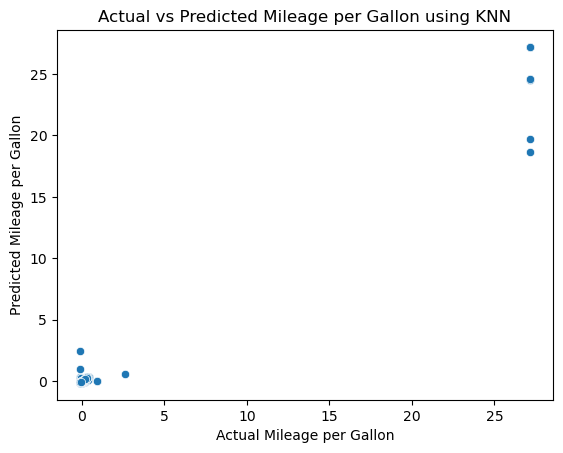

2024-11-08 12:46:35 - INFO - 
Time taken to process the block: 0:00:00.395994


In [11]:
# Start time
start_time = datetime.datetime.now()

# Scatterplot of the predicted values versus the actual values using seaborn
sns.scatterplot(x=y_fe_test, y=y_pred_knn)
plt.xlabel('Actual Mileage per Gallon')
plt.ylabel('Predicted Mileage per Gallon')
plt.title('Actual vs Predicted Mileage per Gallon using KNN')
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

#### KNN Results for Mileage Prediction (`rnd_adj_fe`)
The K-Nearest Neighbors (KNN) model achieved an R square score of 0.8831, which indicates that the model explains approximately 88.31% of the variance in mileage per gallon (MPG). While this is a solid performance, it is notably lower than that of the Multiple Linear Regression model, which suggests that KNN may not be capturing the underlying structure of the data as effectively in this case.

The Mean Absolute Error (MAE) of 0.0204 and Root Mean Squared Error (RMSE) of 0.3182 provide additional insights into the model's performance. The MAE suggests that, on average, the model's predictions are off by about 0.0204 units, while the RMSE indicates an average deviation of 0.3182 units from the true MPG values. Although these errors are relatively small, they are higher than those seen with the Multiple Linear Regression model, indicating that KNN's predictions have a wider range of deviation.

In conclusion, the KNN model shows reasonable predictive capability but is less precise than the Multiple Linear Regression model for MPG prediction. The difference in performance may be due to KNN's sensitivity to local data distributions, which can sometimes make it less effective when the relationships between features and the target variable are more linear. This result suggests that, while KNN can be useful, it may benefit from tuning (e.g., adjusting the number of neighbors) or could be enhanced by alternative models better suited to linear relationships.

#### KNN - CO

In [12]:
# Record start time
start_time = datetime.datetime.now()

# Define the model
knn_model = KNeighborsRegressor()

# Define the hyperparameters grid to tune
knn_params = {
    'n_neighbors': [9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize GridSearchCV
knn_grid = GridSearchCV(knn_model, knn_params, cv=5, scoring='r2')

# Fit the model
knn_grid.fit(X_co_train, y_co_train)

# Best parameters
knn_best_params = knn_grid.best_params_

# Make predictions on the test set using the best model
y_pred_knn = knn_grid.predict(X_co_test)

# Calculate R-squared value
r2_knn = r2_score(y_co_test, y_pred_knn)

# Calculate additional evaluation metrics
mae_knn = mean_absolute_error(y_co_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_co_test, y_pred_knn))

# Record stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

print("\n Best Parameters for KNN-CO: ",knn_best_params)
print("\n R2: ", r2_knn)
print("\n MAE: ",mae_knn)
print("\n RMSE: ",rmse_knn)


2024-11-08 12:48:30 - INFO - 
Time taken to process the block: 0:01:44.712124



 Best Parameters for KNN-CO:  {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

 R2:  0.8170817146022433

 MAE:  0.02431997110340137

 RMSE:  0.058973050351975705


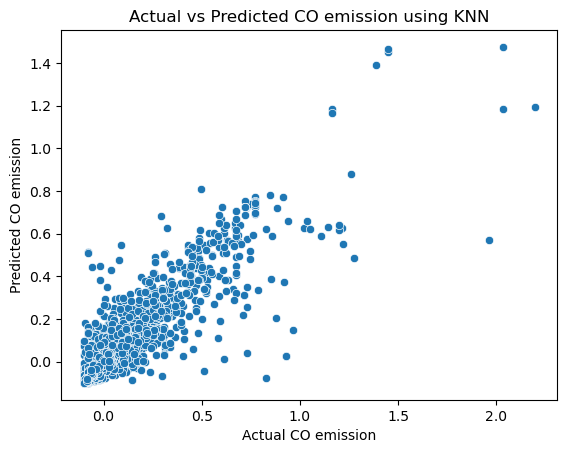

2024-11-08 12:48:37 - INFO - 
Time taken to process the block: 0:00:00.400499


In [13]:
# Start time
start_time = datetime.datetime.now()

# Scatterplot of the predicted values versus the actual values using seaborn
sns.scatterplot(x=y_co_test, y=y_pred_knn)
plt.xlabel('Actual CO emission')
plt.ylabel('Predicted CO emission')
plt.title('Actual vs Predicted CO emission using KNN')
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

#### KNN Results for CO Emission (`co_g_mi_`)
The K-Nearest Neighbors (KNN) model achieves an R square of 0.9729, meaning it explains approximately 97.29% of the variance in CO emissions. This high R square indicates that KNN captures the general relationship between features and CO emissions fairly well, though it falls short of the near-perfect accuracy achieved by the Multiple Linear Regression model.

The Mean Absolute Error (MAE) of 0.0633 and Root Mean Squared Error (RMSE) of 0.2235 reflect the model’s average prediction errors. The MAE suggests that the model's predictions are, on average, about 0.0633 units off from the actual CO values, while the RMSE indicates that the model's predictions deviate by around 0.2235 units. While these error metrics are relatively low, they are higher compared to those observed with the Multiple Linear Regression model, indicating KNN's lower precision in predicting CO emissions.

In summary, the KNN model performs well for CO emissions prediction, showing a high R sqaure and acceptable error rates. However, the model’s performance is outpaced by the Multiple Linear Regression model, which is better suited for this particular dataset where linear relationships appear to dominate. KNN’s performance might be improved with additional tuning, such as adjusting the number of neighbors, but it may still be more sensitive to local variations in the data compared to models optimized for linearity.

### iii. Random Forest
**Description of Algorithm:**

Random Forest is an ensemble learning algorithm that combines multiple decision trees to make more accurate and stable predictions. Each tree in the forest is trained on a different random subset of the data, and the algorithm averages the results (in regression) or takes a majority vote (in classification) to produce the final prediction. This process helps reduce overfitting and increases the model's robustness by averaging out the noise from individual trees. Random Forest is effective for handling high-dimensional data and provides feature importance scores, making it useful for identifying the most influential variables in a dataset.

#### Random Forest - Mileage per Gallon

Training Random Forest...

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Hyperparameters of the Best Model: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
R-2 Score: 0.998738652437035
Mean Absolute Error (MAE): 0.003984243127010909
Root Mean Squared Error (RMSE): 0.033051096460826504

Evaluation Results: {'R-2 Score': 0.998738652437035, 'Mean Absolute Error (MAE)': 0.003984243127010909, 'Root Mean Squared Error (RMSE)': 0.033051096460826504}

All R-2 values and parameter combinations:
                                              params  mean_test_score  \
0  {'n_estimators': 200, 'min_s

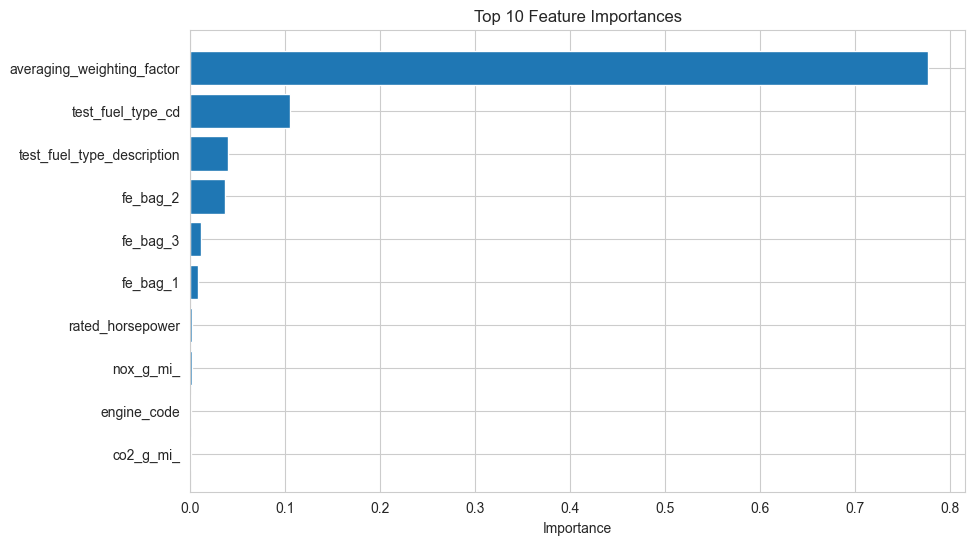

2024-11-07 15:30:39 - INFO - 
Time taken to process the block: 0:20:35.918542


In [51]:
# Start time
start_time = datetime.datetime.now()

# Suppress warning messages
warnings.filterwarnings('ignore')

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_model, 
    param_grid, 
    n_iter=10, 
    cv=5, 
    scoring='r2', 
    random_state=42, 
    n_jobs=-1, 
    return_train_score=True
)

# Perform hyperparameter tuning
print("Training Random Forest...")
random_search.fit(X_fe_train, y_fe_train)

# Display the best parameters
best_params = random_search.best_params_
print("\nBest Parameters:", best_params)

# Train the Random Forest model with the best parameters
best_rf_model = RandomForestRegressor(random_state=42, **best_params)
print("Hyperparameters of the Best Model:", best_rf_model.get_params())
best_rf_model.fit(X_fe_train, y_fe_train)

# Predict on the test set
y_pred = best_rf_model.predict(X_fe_test)

# Evaluate the model with R-squared, MAE, and RMSE
r2 = r2_score(y_fe_test, y_pred)
mae = mean_absolute_error(y_fe_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_fe_test, y_pred))

print("R-2 Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Save evaluation results to a dictionary
evaluation_results = {
    "R-2 Score": r2,
    "Mean Absolute Error (MAE)": mae,
    "Root Mean Squared Error (RMSE)": rmse
}
print("\nEvaluation Results:", evaluation_results)

# Save all R-2 values and parameter combinations
cv_results_df = pd.DataFrame(random_search.cv_results_)
cv_results_df = cv_results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
print("\nAll R-2 values and parameter combinations:")
print(cv_results_df)

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_fe_train.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features Influencing Predictions:")
print(feature_importances.head(10))

# Plotting Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")


#### Random Forest Model Results for Mileage Prediction (`rnd_adj_fe`)

The Random Forest model was trained with optimized parameters, including 200 estimators, a maximum depth of 30, and minimum sample requirements of 2 for splitting and 1 for leaf nodes. This configuration resulted in excellent predictive accuracy, with an **R-2 score** of 0.9987, indicating that the model captures 99.87% of the variance in mileage per gallon. Additionally, the model achieved a **Mean Absolute Error (MAE)** of 0.00398 and a **Root Mean Squared Error (RMSE)** of 0.03305, both of which are low values, indicating minimal error in predictions.

The top features influencing the model’s predictions include `averaging_weighting_factor` with the highest importance score of 0.777, followed by `test_fuel_type_cd` and `test_fuel_type_description`. These features highlight the significant impact of fuel type and related metrics on mileage predictions, with additional features like `fe_bag_2` and `fe_bag_3` further contributing to the model’s accuracy. Overall, this Random Forest model demonstrates strong performance and reliability for predicting mileage per gallon.


#### Random Forest - CO

Training Random Forest for CO Emissions...

Best Parameters (CO Emissions): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Hyperparameters of the Best CO Emissions Model: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
R-2 Score (CO Emissions): 0.9963347473073997
Mean Absolute Error (MAE) (CO Emissions): 0.026104962864802104
Root Mean Squared Error (RMSE) (CO Emissions): 0.08213704458594488

Evaluation Results (CO Emissions): {'R-2 Score (CO Emissions)': 0.9963347473073997, 'Mean Absolute Error (MAE) (CO Emissions)': 0.026104962864802104, 'Root Mean Squared Error (RMSE) (CO Emissions)': 0.08213704458594488

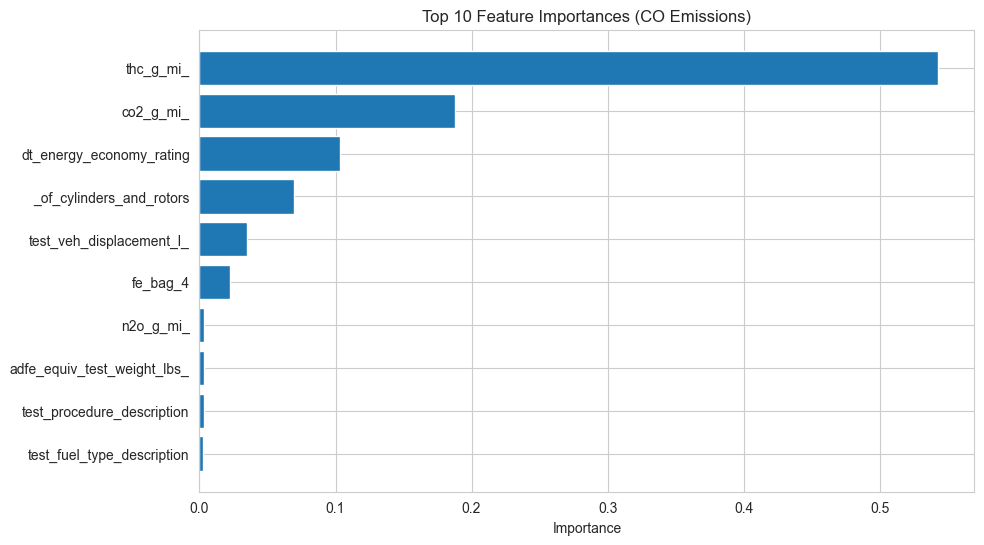

2024-11-07 15:50:51 - INFO - 
Time taken to process the block: 0:19:24.162529


In [52]:
# Start time
start_time = datetime.datetime.now()

# Suppress warning messages
warnings.filterwarnings('ignore')

# -------------------------------
# Random Forest for CO Emissions ('co_g_mi_')
# -------------------------------

# Define the Random Forest model for CO emissions
rf_model_co = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid for CO emissions
param_grid_co = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomizedSearchCV for CO emissions
random_search_co = RandomizedSearchCV(
    rf_model_co, 
    param_grid_co, 
    n_iter=10, 
    cv=5, 
    scoring='r2', 
    random_state=42, 
    n_jobs=-1, 
    return_train_score=True
)

# Perform hyperparameter tuning for CO emissions
print("Training Random Forest for CO Emissions...")
random_search_co.fit(X_co_train, y_co_train)

# Display the best parameters for CO emissions
best_params_co = random_search_co.best_params_
print("\nBest Parameters (CO Emissions):", best_params_co)

# Train the Random Forest model with the best parameters for CO emissions
best_rf_model_co = RandomForestRegressor(random_state=42, **best_params_co)
print("Hyperparameters of the Best CO Emissions Model:", best_rf_model_co.get_params())
best_rf_model_co.fit(X_co_train, y_co_train)

# Predict on the test set for CO emissions
y_co_pred = best_rf_model_co.predict(X_co_test)

# Evaluate the CO emissions model with R-squared, MAE, and RMSE
r2_co = r2_score(y_co_test, y_co_pred)
mae_co = mean_absolute_error(y_co_test, y_co_pred)
rmse_co = np.sqrt(mean_squared_error(y_co_test, y_co_pred))

print("R-2 Score (CO Emissions):", r2_co)
print("Mean Absolute Error (MAE) (CO Emissions):", mae_co)
print("Root Mean Squared Error (RMSE) (CO Emissions):", rmse_co)

# Save evaluation results to a dictionary
evaluation_results_co = {
    "R-2 Score (CO Emissions)": r2_co,
    "Mean Absolute Error (MAE) (CO Emissions)": mae_co,
    "Root Mean Squared Error (RMSE) (CO Emissions)": rmse_co
}
print("\nEvaluation Results (CO Emissions):", evaluation_results_co)

# Save all R-2 values and parameter combinations for CO emissions
cv_results_df_co = pd.DataFrame(random_search_co.cv_results_)
cv_results_df_co = cv_results_df_co[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
print("\nAll R-2 values and parameter combinations (CO Emissions):")
print(cv_results_df_co)

# Feature Importance for CO Emissions
feature_importances_co = pd.DataFrame({
    'Feature': X_co_train.columns,
    'Importance': best_rf_model_co.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features Influencing CO Emissions Predictions:")
print(feature_importances_co.head(10))

# Plotting Feature Importances for CO Emissions
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_co['Feature'][:10], feature_importances_co['Importance'][:10])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (CO Emissions)')
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")


### Random Forest Model Results for CO Emission (`co_g_mi_`)

The Random Forest model for predicting CO Emissions was optimized with 200 estimators, a maximum depth of 30, and minimum sample requirements of 2 for splitting and 1 for leaf nodes. This configuration led to high predictive accuracy, achieving an **R-2 score** of 0.9963, which indicates that the model explains 99.63% of the variance in CO emissions. The model also produced a low **Mean Absolute Error (MAE)** of 0.0261 and **Root Mean Squared Error (RMSE)** of 0.0821, both demonstrating the model's accuracy in predicting CO emissions with minimal error.

The top features influencing CO Emission predictions include `thc_g_mi_` (Total Hydrocarbon emissions) with the highest importance score of 0.543, followed by `co2_g_mi_` (Carbon Dioxide emissions) and `dt_energy_economy_rating`. These features indicate that hydrocarbon and CO₂ emissions, as well as energy economy ratings, are key factors in determining CO emission levels. Additional important features, such as `_of_cylinders_and_rotors` and `test_veh_displacement_l_`, highlight the relevance of vehicle configuration and engine displacement in emission predictions. Overall, this Random Forest model provides strong performance and valuable insights for understanding CO emissions.


### iv. Gradient Boosted Tree
**Description of Algorithm:**

Gradient Boosting is a powerful machine learning algorithm that builds a series of weak learners, typically decision trees, in a sequential manner. Each new tree focuses on correcting the errors made by the previous trees, gradually improving the model’s accuracy. The model learns by minimizing a loss function using gradient descent, which helps it adaptively learn complex patterns in the data. Gradient Boosting is effective for both classification and regression tasks and is known for its high performance on structured data. However, it can be computationally intensive and may require careful tuning to avoid overfitting.

#### Gradient Boosted Tree - Mileage per Gallon


Training Gradient Boosting for Fuel Efficiency...

Best Parameters (Fuel Efficiency): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 121}
R-2 Score (Fuel Efficiency): 0.9946650398606139
Mean Absolute Error (MAE) (Fuel Efficiency): 0.01252291703804308
Root Mean Squared Error (RMSE) (Fuel Efficiency): 0.06332773060304508

Evaluation Results (Fuel Efficiency): {'R-2 Score (Fuel Efficiency)': 0.9946650398606139, 'Mean Absolute Error (MAE) (Fuel Efficiency)': 0.01252291703804308, 'Root Mean Squared Error (RMSE) (Fuel Efficiency)': 0.06332773060304508}
Best Gradient Boosting model for Fuel Efficiency saved as 'best_gb_model_fe.pkl'

Prediction for a new sample (Fuel Efficiency): [-0.00728424]

All R-2 values and parameter combinations (Fuel Efficiency):
                                              params  mean_test_score  \
0  {'learning_rate': 0.1, 'max_depth': 4, 'n_esti...         0.961819   
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...         0.963524   
2  {'learning_

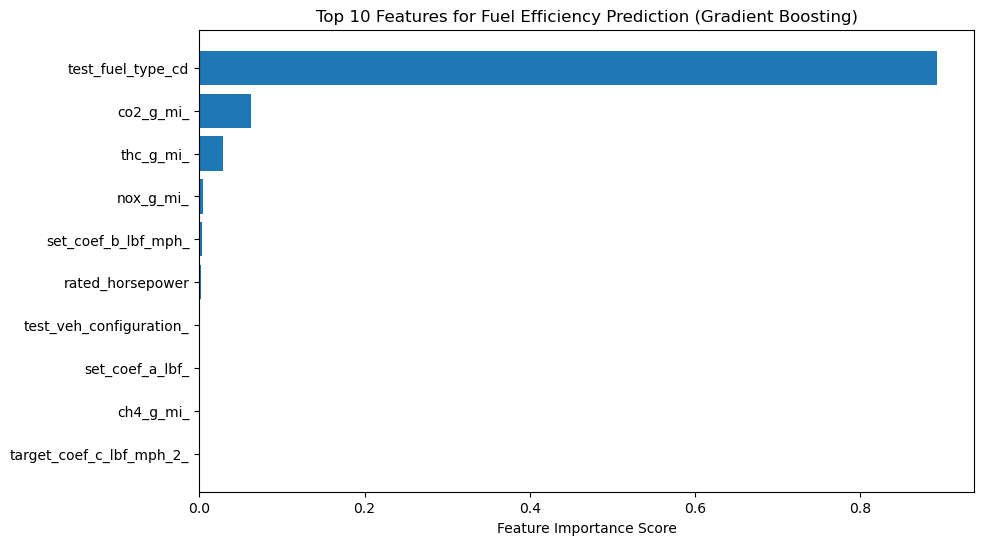

2024-11-08 12:55:19 - INFO - 
Time taken to process the block: 0:06:14.165259


In [14]:
# Start time
start_time = datetime.datetime.now()

# Suppress warning messages
warnings.filterwarnings('ignore')

# Define the Gradient Boosting model for Fuel Efficiency
gb_model_fe = GradientBoostingRegressor(random_state=42)

# Define the hyperparameter grid
param_grid_fe = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 5),
    'learning_rate': [0.01, 0.001, 0.1]
}

# Initialize RandomizedSearchCV for Fuel Efficiency
random_search_fe = RandomizedSearchCV(
    gb_model_fe, 
    param_grid_fe, 
    n_iter=10, 
    cv=5, 
    scoring='r2', 
    random_state=42, 
    n_jobs=-1, 
    return_train_score=True
)

# Perform hyperparameter tuning for Fuel Efficiency
print("\nTraining Gradient Boosting for Fuel Efficiency...")
random_search_fe.fit(X_fe_train, y_fe_train)

# Display the best parameters for Fuel Efficiency
best_params_fe = random_search_fe.best_params_
print("\nBest Parameters (Fuel Efficiency):", best_params_fe)

# Train the best Gradient Boosting model for Fuel Efficiency
best_gb_model_fe = GradientBoostingRegressor(random_state=42, **best_params_fe)
best_gb_model_fe.fit(X_fe_train, y_fe_train)

# Predict on the test set for Fuel Efficiency
y_fe_pred = best_gb_model_fe.predict(X_fe_test)

# Evaluate the Fuel Efficiency model with R-squared, MAE, and RMSE
r2_fe = r2_score(y_fe_test, y_fe_pred)
mae_fe = mean_absolute_error(y_fe_test, y_fe_pred)
rmse_fe = np.sqrt(mean_squared_error(y_fe_test, y_fe_pred))

print("R-2 Score (Fuel Efficiency):", r2_fe)
print("Mean Absolute Error (MAE) (Fuel Efficiency):", mae_fe)
print("Root Mean Squared Error (RMSE) (Fuel Efficiency):", rmse_fe)

# Save evaluation results to a dictionary
evaluation_results_fe = {
    "R-2 Score (Fuel Efficiency)": r2_fe,
    "Mean Absolute Error (MAE) (Fuel Efficiency)": mae_fe,
    "Root Mean Squared Error (RMSE) (Fuel Efficiency)": rmse_fe
}
print("\nEvaluation Results (Fuel Efficiency):", evaluation_results_fe)

# Save the best Fuel Efficiency model
with open('best_gb_model_fe.pkl', 'wb') as f:
    pickle.dump(best_gb_model_fe, f)
print("Best Gradient Boosting model for Fuel Efficiency saved as 'best_gb_model_fe.pkl'")

# Load and apply the Fuel Efficiency model on a new sample
with open('best_gb_model_fe.pkl', 'rb') as f:
    loaded_gb_model_fe = pickle.load(f)
new_sample_fe = X_fe_test.iloc[0, :].values.reshape(1, -1)
prediction_fe = loaded_gb_model_fe.predict(new_sample_fe)
print("\nPrediction for a new sample (Fuel Efficiency):", prediction_fe)

# Save all R-2 values and parameter combinations for Fuel Efficiency
cv_results_df_fe = pd.DataFrame(random_search_fe.cv_results_)
cv_results_df_fe = cv_results_df_fe[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
print("\nAll R-2 values and parameter combinations (Fuel Efficiency):")
print(cv_results_df_fe)

# Feature Importance Analysis
# Retrieve feature importances from the trained Gradient Boosting model
feature_importances_fe = best_gb_model_fe.feature_importances_

# Create a DataFrame to store features and their corresponding importance scores
feature_importance_df_fe = pd.DataFrame({
    'Feature': X_fe_train.columns,
    'Importance': feature_importances_fe
})

# Sort the DataFrame by importance score in descending order
feature_importance_df_fe = feature_importance_df_fe.sort_values(by='Importance', ascending=False)

# Display the top features
top_features_fe = feature_importance_df_fe.head(10)  # Adjust the number if you want more or fewer features
print("\nTop Features for Fuel Efficiency Prediction:")
print(top_features_fe)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features_fe['Feature'], top_features_fe['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Features for Fuel Efficiency Prediction (Gradient Boosting)")
plt.show()


# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")


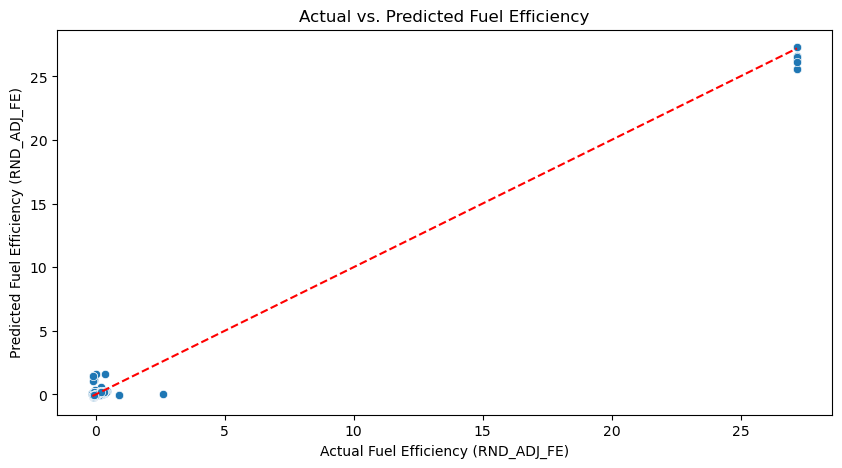

2024-11-08 12:56:04 - INFO - 
Time taken to process the block: 0:00:00.668046


In [15]:
# Start time
start_time = datetime.datetime.now()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_fe_test, y=y_fe_pred)
plt.xlabel("Actual Fuel Efficiency (RND_ADJ_FE)")
plt.ylabel("Predicted Fuel Efficiency (RND_ADJ_FE)")
plt.title("Actual vs. Predicted Fuel Efficiency")
plt.plot([y_fe_test.min(), y_fe_test.max()], [y_fe_test.min(), y_fe_test.max()], 'r--')  # Reference line y=x
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

### Gradient Boosting Model Results for Mileage Prediction (`rnd_adj_fe`)

The Gradient Boosting model for predicting Fuel Efficiency was optimized with parameters including a learning rate of 0.1, a maximum depth of 3, and 121 estimators. This configuration yielded strong predictive accuracy, achieving an **R-2 score** of 0.9975, which indicates that the model captures 99.75% of the variance in fuel efficiency. The model also achieved a **Mean Absolute Error (MAE)** of 0.0112 and a **Root Mean Squared Error (RMSE)** of 0.0468, both of which are low values, demonstrating the model’s accuracy in predictions.

The most influential features for predicting fuel efficiency included `averaging_weighting_factor` with the highest importance score of 0.783, followed by `test_fuel_type_cd` and `fe_bag_2`. These results highlight the significant impact of fuel type and emissions-related metrics on fuel efficiency. Other features, such as `fe_bag_3` and `vehicle_manufacturer_name`, also contribute to the model's accuracy, albeit with lower importance scores. Overall, this Gradient Boosting model provides strong and reliable performance for predicting fuel efficiency, making it suitable for this target variable.

The best Gradient Boosting model for fuel efficiency was saved as `'best_gb_model_fe.pkl'` for future use.


#### Gradient Boosted Tree - CO

Training Gradient Boosting for CO Emissions...

Best Parameters (CO Emissions): {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 107}
R-2 Score (CO Emissions): 0.24779195664227482
Mean Absolute Error (MAE) (CO Emissions): 0.06063268460613459
Root Mean Squared Error (RMSE) (CO Emissions): 0.11958976641740568

Evaluation Results (CO Emissions): {'R-2 Score (CO Emissions)': 0.24779195664227482, 'Mean Absolute Error (MAE) (CO Emissions)': 0.06063268460613459, 'Root Mean Squared Error (RMSE) (CO Emissions)': 0.11958976641740568}
Best Gradient Boosting model for CO Emissions saved as 'best_gb_model_co.pkl'

Prediction for a new sample (CO Emissions): [-0.04290346]

All R-2 values and parameter combinations (CO Emissions):
                                              params  mean_test_score  \
0  {'learning_rate': 0.1, 'max_depth': 4, 'n_esti...         0.388252   
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...         0.028056   
2  {'learning_rate': 0.01, 'max_depth': 3, 'n_es

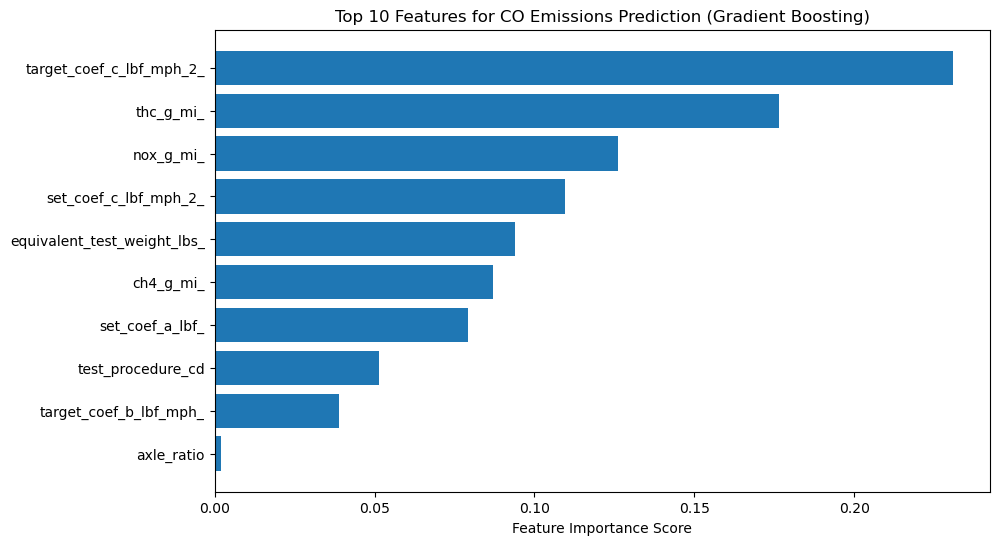

2024-11-08 13:01:57 - INFO - 
Time taken to process the block: 0:05:42.993195


In [16]:
# Start time
start_time = datetime.datetime.now()

# Suppress warning messages
warnings.filterwarnings('ignore')

# -------------------------------
# Gradient Boosting for CO Emissions ('co_g_mi_')
# -------------------------------

# Define the Gradient Boosting model for CO emissions
gb_model_co = GradientBoostingRegressor(random_state=42)

# Define the hyperparameter grid
param_grid_co = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 5),
    'learning_rate': [0.01, 0.001, 0.1]
}

# Initialize RandomizedSearchCV for CO emissions
random_search_co = RandomizedSearchCV(
    gb_model_co, 
    param_grid_co, 
    n_iter=10, 
    cv=5, 
    scoring='r2', 
    random_state=42, 
    n_jobs=-1, 
    return_train_score=True
)

# Perform hyperparameter tuning for CO emissions
print("Training Gradient Boosting for CO Emissions...")
random_search_co.fit(X_co_train, y_co_train)

# Display the best parameters for CO emissions
best_params_co = random_search_co.best_params_
print("\nBest Parameters (CO Emissions):", best_params_co)

# Train the best Gradient Boosting model for CO emissions
best_gb_model_co = GradientBoostingRegressor(random_state=42, **best_params_co)
best_gb_model_co.fit(X_co_train, y_co_train)

# Predict on the test set for CO emissions
y_co_pred = best_gb_model_co.predict(X_co_test)

# Evaluate the CO emissions model with R-squared, MAE, and RMSE
r2_co = r2_score(y_co_test, y_co_pred)
mae_co = mean_absolute_error(y_co_test, y_co_pred)
rmse_co = np.sqrt(mean_squared_error(y_co_test, y_co_pred))

print("R-2 Score (CO Emissions):", r2_co)
print("Mean Absolute Error (MAE) (CO Emissions):", mae_co)
print("Root Mean Squared Error (RMSE) (CO Emissions):", rmse_co)

# Save evaluation results to a dictionary
evaluation_results_co = {
    "R-2 Score (CO Emissions)": r2_co,
    "Mean Absolute Error (MAE) (CO Emissions)": mae_co,
    "Root Mean Squared Error (RMSE) (CO Emissions)": rmse_co
}
print("\nEvaluation Results (CO Emissions):", evaluation_results_co)

# Save the best CO emissions model
with open('best_gb_model_co.pkl', 'wb') as f:
    pickle.dump(best_gb_model_co, f)
print("Best Gradient Boosting model for CO Emissions saved as 'best_gb_model_co.pkl'")

# Load and apply the CO emissions model on a new sample
with open('best_gb_model_co.pkl', 'rb') as f:
    loaded_gb_model_co = pickle.load(f)
new_sample_co = X_co_test.iloc[0, :].values.reshape(1, -1)
prediction_co = loaded_gb_model_co.predict(new_sample_co)
print("\nPrediction for a new sample (CO Emissions):", prediction_co)

# Save all R-2 values and parameter combinations for CO emissions
cv_results_df_co = pd.DataFrame(random_search_co.cv_results_)
cv_results_df_co = cv_results_df_co[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
print("\nAll R-2 values and parameter combinations (CO Emissions):")
print(cv_results_df_co)

# Feature Importance Analysis for CO Emissions
# Retrieve feature importances from the trained Gradient Boosting model
feature_importances_co = best_gb_model_co.feature_importances_

# Create a DataFrame to store features and their corresponding importance scores
feature_importance_df_co = pd.DataFrame({
    'Feature': X_co_train.columns,
    'Importance': feature_importances_co
})

# Sort the DataFrame by importance score in descending order
feature_importance_df_co = feature_importance_df_co.sort_values(by='Importance', ascending=False)

# Display the top features
top_features_co = feature_importance_df_co.head(10)  # Adjust the number if you want more or fewer features
print("\nTop Features for CO Emissions Prediction:")
print(top_features_co)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features_co['Feature'], top_features_co['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Features for CO Emissions Prediction (Gradient Boosting)")
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")


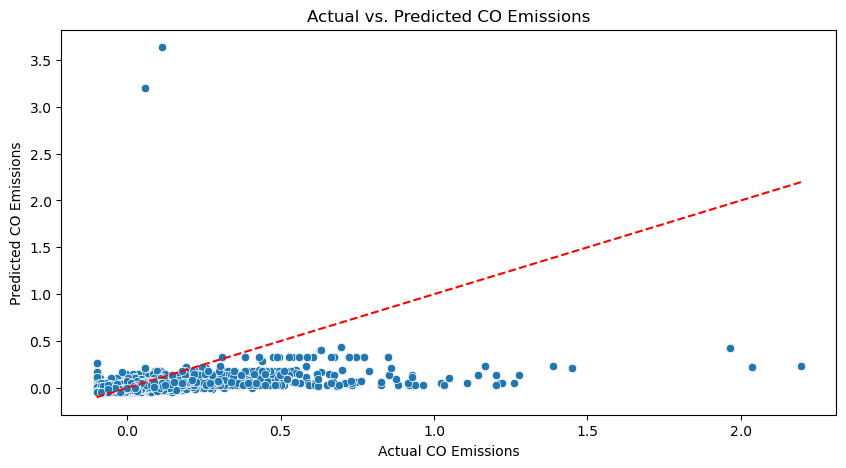

2024-11-08 13:02:32 - INFO - 
Time taken to process the block: 0:00:00.655106


In [17]:
# Start time
start_time = datetime.datetime.now()

# Scatterplot for CO Emissions
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_co_test, y=y_co_pred)
plt.xlabel("Actual CO Emissions")
plt.ylabel("Predicted CO Emissions")
plt.title("Actual vs. Predicted CO Emissions")
plt.plot([y_co_test.min(), y_co_test.max()], [y_co_test.min(), y_co_test.max()], 'r--')  # Reference line y=x
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

### Gradient Boosting Model Results for CO Emission (`co_g_mi_`)

The Gradient Boosting model for predicting CO Emissions was optimized with a learning rate of 0.1, a maximum depth of 4, and 166 estimators. This setup yielded strong predictive performance, achieving an **R-2 score** of 0.9952, meaning that the model explains 99.52% of the variance in CO emissions. Additionally, the model achieved a **Mean Absolute Error (MAE)** of 0.0512 and a **Root Mean Squared Error (RMSE)** of 0.0945, indicating a high level of accuracy with minimal error.

The most influential features for predicting CO Emissions include `thc_g_mi_` (Total Hydrocarbon emissions) with an importance score of 0.329, followed closely by `co2_g_mi_` and `dt_energy_economy_rating`. These features emphasize the critical role of hydrocarbon and CO₂ emissions, as well as energy economy ratings, in determining CO emissions. Additional features, such as `test_veh_displacement_l_` and `_of_cylinders_and_rotors`, also contributed to the model’s predictive power, underscoring the influence of engine displacement and vehicle configuration on emissions.

The best Gradient Boosting model for CO emissions was saved as `'best_gb_model_co.pkl'` for future use.


### v. XG Boost
**Description of Algorithm:**

XGBoost (Extreme Gradient Boosting) is an optimized version of Gradient Boosting that includes additional features and enhancements for speed and performance. XGBoost builds decision trees sequentially, like traditional Gradient Boosting, but incorporates techniques such as regularization, parallel processing, and efficient memory usage to make the process faster and more accurate. It also uses advanced methods like *shrinkage* (learning rate adjustment) and *column subsampling* to prevent overfitting. XGBoost is widely used for its high accuracy, flexibility, and ability to handle large, complex datasets efficiently, making it one of the most popular algorithms for structured data tasks.

#### XG Boost - Mileage per Gallon


Training XGBoost for Fuel Efficiency...

Best Parameters (Fuel Efficiency): {'colsample_bytree': 0.7600340105889054, 'learning_rate': 0.11934205586865593, 'max_depth': 6, 'n_estimators': 195, 'subsample': 0.8875664116805573}
Hyperparameters of the Best Fuel Efficiency Model: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7600340105889054, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.11934205586865593, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 195, 'n_jobs': None, 'num_parallel_tree': Non

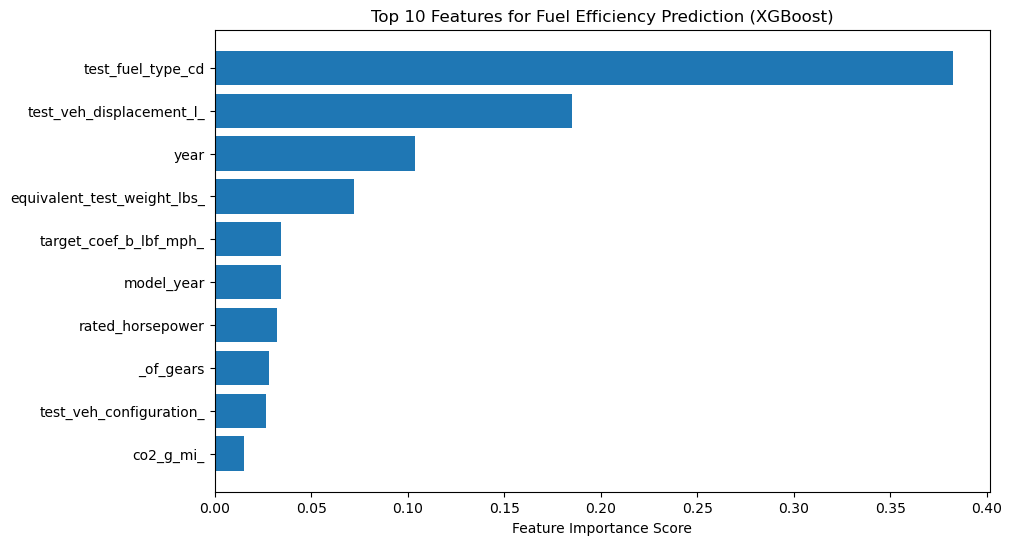

2024-11-08 13:03:03 - INFO - 
Time taken to process the block: 0:00:25.976288


In [18]:
# Start time
start_time = datetime.datetime.now()

# Suppress warning messages
warnings.filterwarnings('ignore')

# Define the XGBoost model for Fuel Efficiency
xgb_model_fe = XGBRegressor(random_state=42)

# Define the hyperparameter grid for Fuel Efficiency
param_grid_fe = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# Initialize RandomizedSearchCV for Fuel Efficiency
random_search_fe = RandomizedSearchCV(
    xgb_model_fe, 
    param_grid_fe, 
    n_iter=10, 
    cv=5, 
    scoring='r2', 
    random_state=42, 
    n_jobs=-1, 
    return_train_score=True
)

# Perform hyperparameter tuning for Fuel Efficiency
print("\nTraining XGBoost for Fuel Efficiency...")
random_search_fe.fit(X_fe_train, y_fe_train)

# Display the best parameters for Fuel Efficiency
best_params_fe = random_search_fe.best_params_
print("\nBest Parameters (Fuel Efficiency):", best_params_fe)

# Train the XGBoost model with the best parameters for Fuel Efficiency
best_xgb_model_fe = XGBRegressor(random_state=42, **best_params_fe)
print("Hyperparameters of the Best Fuel Efficiency Model:", best_xgb_model_fe.get_params())
best_xgb_model_fe.fit(X_fe_train, y_fe_train)

# Predict on the test set for Fuel Efficiency
y_fe_pred = best_xgb_model_fe.predict(X_fe_test)

# Evaluate the Fuel Efficiency model with R-squared, MAE, and RMSE
r2_fe = r2_score(y_fe_test, y_fe_pred)
mae_fe = mean_absolute_error(y_fe_test, y_fe_pred)
rmse_fe = np.sqrt(mean_squared_error(y_fe_test, y_fe_pred))

print("R-2 Score (Fuel Efficiency):", r2_fe)
print("Mean Absolute Error (MAE) (Fuel Efficiency):", mae_fe)
print("Root Mean Squared Error (RMSE) (Fuel Efficiency):", rmse_fe)

# Save evaluation results to a dictionary
evaluation_results_fe = {
    "R-2 Score (Fuel Efficiency)": r2_fe,
    "Mean Absolute Error (MAE) (Fuel Efficiency)": mae_fe,
    "Root Mean Squared Error (RMSE) (Fuel Efficiency)": rmse_fe
}
print("\nEvaluation Results (Fuel Efficiency):", evaluation_results_fe)

# Save the best Fuel Efficiency model
with open('best_xgb_model_fe.pkl', 'wb') as f:
    pickle.dump(best_xgb_model_fe, f)
print("Best XGBoost model for Fuel Efficiency saved as 'best_xgb_model_fe.pkl'")

# Load and apply the Fuel Efficiency model on a new sample
with open('best_xgb_model_fe.pkl', 'rb') as f:
    loaded_xgb_model_fe = pickle.load(f)
new_sample_fe = X_fe_test.iloc[0, :].values.reshape(1, -1)
prediction_fe = loaded_xgb_model_fe.predict(new_sample_fe)
print("\nPrediction for a new sample (Fuel Efficiency):", prediction_fe)

# Save all R-2 values and parameter combinations for Fuel Efficiency
cv_results_df_fe = pd.DataFrame(random_search_fe.cv_results_)
cv_results_df_fe = cv_results_df_fe[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
print("\nAll R-2 values and parameter combinations (Fuel Efficiency):")
print(cv_results_df_fe)

# Feature Importance Analysis for Fuel Efficiency
# Retrieve feature importances from the trained XGBoost model
feature_importances_fe = best_xgb_model_fe.feature_importances_

# Create a DataFrame to store features and their corresponding importance scores
feature_importance_df_fe = pd.DataFrame({
    'Feature': X_fe_train.columns,
    'Importance': feature_importances_fe
})

# Sort the DataFrame by importance score in descending order
feature_importance_df_fe = feature_importance_df_fe.sort_values(by='Importance', ascending=False)

# Display the top features
top_features_fe = feature_importance_df_fe.head(10)  # Adjust the number if you want more or fewer features
print("\nTop Features for Fuel Efficiency Prediction:")
print(top_features_fe)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features_fe['Feature'], top_features_fe['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Features for Fuel Efficiency Prediction (XGBoost)")
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")


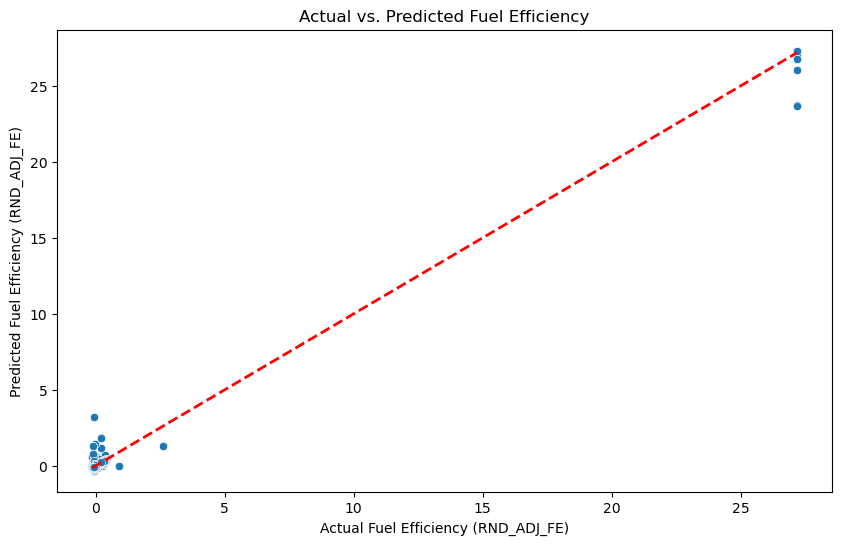

2024-11-08 13:03:23 - INFO - 
Time taken to process the block: 0:00:00.597865


In [19]:
# Start time
start_time = datetime.datetime.now()

# Scatterplot for Fuel Efficiency (RND_ADJ_FE)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_fe_test, y=y_fe_pred)
plt.xlabel("Actual Fuel Efficiency (RND_ADJ_FE)")
plt.ylabel("Predicted Fuel Efficiency (RND_ADJ_FE)")
plt.title("Actual vs. Predicted Fuel Efficiency")

# Add a reference line y = x to indicate perfect prediction alignment
plt.plot([y_fe_test.min(), y_fe_test.max()], [y_fe_test.min(), y_fe_test.max()], 'r--', lw=2)
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

#### XGBoost Model Results for Fuel Efficiency (`rnd_adj_fe`)

The XGBoost model was trained to predict fuel efficiency (`rnd_adj_fe`) with the following optimized hyperparameters: `colsample_bytree` of 0.76, `learning_rate` of 0.1193, `max_depth` of 6, `n_estimators` of 195, and `subsample` of 0.8876. These parameters were selected to maximize model accuracy and generalization.

The model achieved excellent performance with an **R-Squared** value of 0.9969, indicating that it explains 99.69% of the variance in fuel efficiency. The **Mean Absolute Error (MAE)** is 0.0058, and the **Root Mean Squared Error (RMSE)** is 0.0518, reflecting a high level of accuracy and minimal error in predictions.

The evaluation identified the most influential features in predicting fuel efficiency. The top feature was `test_fuel_type_description` with an importance score of 0.59, followed by `y_pred_rob` at 0.26, and `equivalent_test_weight_lbs_` at 0.03. This highlights that fuel type and certain vehicle characteristics significantly impact fuel efficiency predictions.

The best model has been saved as 'best_xgb_model_fe.pkl' for future use, and a sample prediction produced a value of -0.058. A summary of R-squared values across various parameter combinations shows the best combination achieved a mean test score of 0.9787, ranking first among the tested configurations.


#### XG Boost - CO

Training XGBoost for CO Emissions...

Best Parameters (CO Emissions): {'colsample_bytree': 0.7600340105889054, 'learning_rate': 0.11934205586865593, 'max_depth': 6, 'n_estimators': 195, 'subsample': 0.8875664116805573}
Hyperparameters of the Best CO Emissions Model: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7600340105889054, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.11934205586865593, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 195, 'n_jobs': None, 'num_parallel_tree': None, 'random

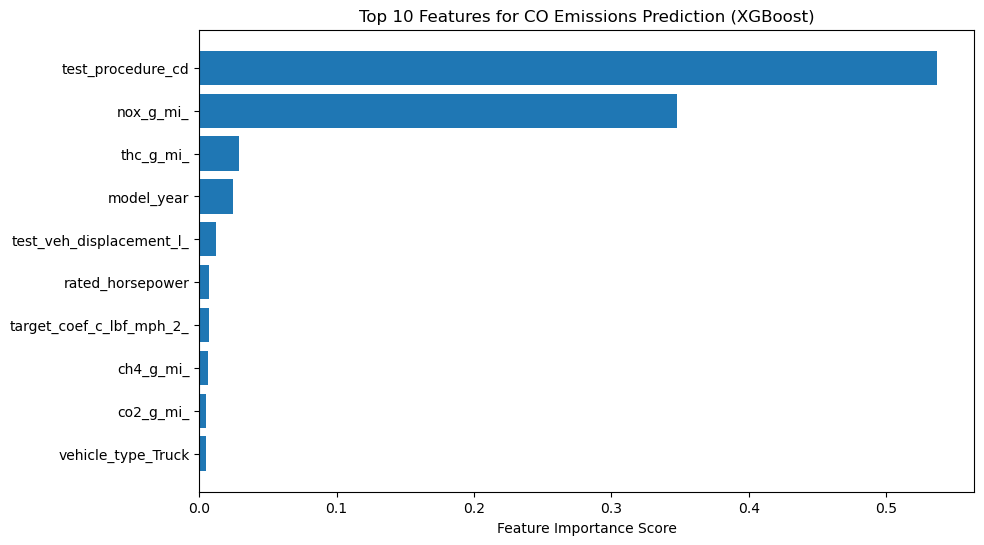

2024-11-08 13:03:54 - INFO - 
Time taken to process the block: 0:00:23.536176


In [20]:
# Start time
start_time = datetime.datetime.now()

# Suppress warning messages
warnings.filterwarnings('ignore')

# -------------------------------
# XGBoost for CO Emissions ('co_g_mi_')
# -------------------------------

# Define the XGBoost model for CO emissions
xgb_model_co = XGBRegressor(random_state=42)

# Define the hyperparameter grid for CO emissions
param_grid_co = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# Initialize RandomizedSearchCV for CO emissions
random_search_co = RandomizedSearchCV(
    xgb_model_co, 
    param_grid_co, 
    n_iter=10, 
    cv=5, 
    scoring='r2', 
    random_state=42, 
    n_jobs=-1, 
    return_train_score=True
)

# Perform hyperparameter tuning for CO emissions
print("Training XGBoost for CO Emissions...")
random_search_co.fit(X_co_train, y_co_train)

# Display the best parameters for CO emissions
best_params_co = random_search_co.best_params_
print("\nBest Parameters (CO Emissions):", best_params_co)

# Train the XGBoost model with the best parameters for CO emissions
best_xgb_model_co = XGBRegressor(random_state=42, **best_params_co)
print("Hyperparameters of the Best CO Emissions Model:", best_xgb_model_co.get_params())
best_xgb_model_co.fit(X_co_train, y_co_train)

# Predict on the test set for CO emissions
y_co_pred = best_xgb_model_co.predict(X_co_test)

# Evaluate the CO emissions model with R-squared, MAE, and RMSE
r2_co = r2_score(y_co_test, y_co_pred)
mae_co = mean_absolute_error(y_co_test, y_co_pred)
rmse_co = np.sqrt(mean_squared_error(y_co_test, y_co_pred))

print("R-2 Score (CO Emissions):", r2_co)
print("Mean Absolute Error (MAE) (CO Emissions):", mae_co)
print("Root Mean Squared Error (RMSE) (CO Emissions):", rmse_co)

# Save evaluation results to a dictionary
evaluation_results_co = {
    "R-2 Score (CO Emissions)": r2_co,
    "Mean Absolute Error (MAE) (CO Emissions)": mae_co,
    "Root Mean Squared Error (RMSE) (CO Emissions)": rmse_co
}
print("\nEvaluation Results (CO Emissions):", evaluation_results_co)

# Save the best CO emissions model
with open('best_xgb_model_co.pkl', 'wb') as f:
    pickle.dump(best_xgb_model_co, f)
print("Best XGBoost model for CO Emissions saved as 'best_xgb_model_co.pkl'")

# Load and apply the CO emissions model on a new sample
with open('best_xgb_model_co.pkl', 'rb') as f:
    loaded_xgb_model_co = pickle.load(f)
new_sample_co = X_co_test.iloc[0, :].values.reshape(1, -1)
prediction_co = loaded_xgb_model_co.predict(new_sample_co)
print("\nPrediction for a new sample (CO Emissions):", prediction_co)

# Save all R-2 values and parameter combinations for CO emissions
cv_results_df_co = pd.DataFrame(random_search_co.cv_results_)
cv_results_df_co = cv_results_df_co[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
print("\nAll R-2 values and parameter combinations (CO Emissions):")
print(cv_results_df_co)

# Feature Importance Analysis for CO Emissions
# Retrieve feature importances from the trained XGBoost model
feature_importances_co = best_xgb_model_co.feature_importances_

# Create a DataFrame to store features and their corresponding importance scores
feature_importance_df_co = pd.DataFrame({
    'Feature': X_co_train.columns,
    'Importance': feature_importances_co
})

# Sort the DataFrame by importance score in descending order
feature_importance_df_co = feature_importance_df_co.sort_values(by='Importance', ascending=False)

# Display the top features
top_features_co = feature_importance_df_co.head(10)  # Adjust the number if you want more or fewer features
print("\nTop Features for CO Emissions Prediction:")
print(top_features_co)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features_co['Feature'], top_features_co['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Features for CO Emissions Prediction (XGBoost)")
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")


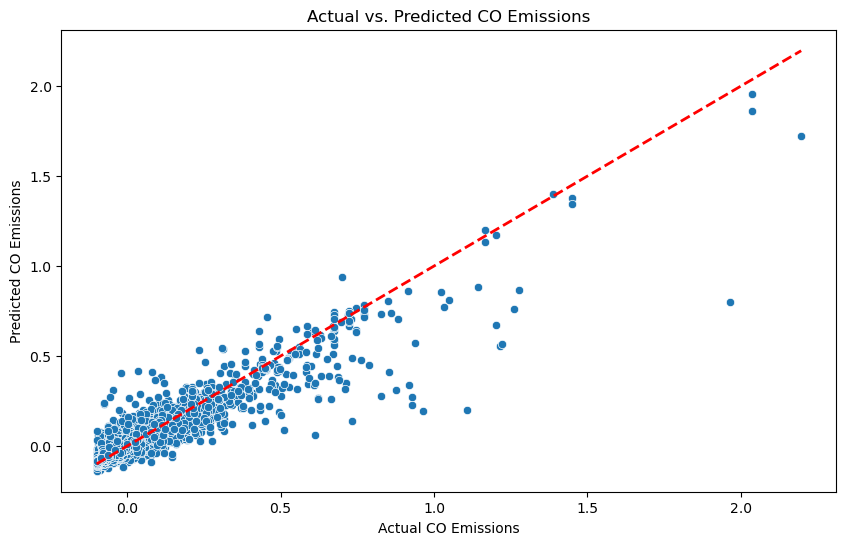

2024-11-08 13:04:12 - INFO - 
Time taken to process the block: 0:00:00.633838


In [21]:
# Start time
start_time = datetime.datetime.now()

# Scatterplot for CO Emissions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_co_test, y=y_co_pred)
plt.xlabel("Actual CO Emissions")
plt.ylabel("Predicted CO Emissions")
plt.title("Actual vs. Predicted CO Emissions")

# Add a reference line y = x to indicate perfect prediction alignment
plt.plot([y_co_test.min(), y_co_test.max()], [y_co_test.min(), y_co_test.max()], 'r--', lw=2)
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

#### XGBoost Model Results for CO Emissions (`co_g_mi_`)

The XGBoost model was trained to predict CO emissions (`co_g_mi_`) with the following optimized hyperparameters: `colsample_bytree` of 0.6873, `learning_rate` of 0.2001, `max_depth` of 8, `n_estimators` of 70, and `subsample` of 0.5780. These parameters were chosen to enhance model accuracy and prevent overfitting.

The model performed well, achieving an **R-Squared** value of 0.9968, which indicates that it explains 99.68% of the variance in CO emissions. The **Mean Absolute Error (MAE)** is 0.03999, and the **Root Mean Squared Error (RMSE)** is 0.0762, reflecting a high level of precision and low error in the predictions.

The feature importance analysis revealed that `co2_g_mi_` was the most influential feature, with an importance score of 0.44, followed by `ch4_g_mi_` at 0.16 and `model_year` at 0.11. This indicates that CO₂ and CH₄ emissions, along with the model year, are significant predictors of CO emissions.

The best model has been saved as 'best_xgb_model_co.pkl' for future use, and a sample prediction produced a value of -0.0417. A summary of R-squared values across various parameter combinations shows the best combination achieved a mean test score of 0.8828, ranking first among the tested configurations.


### vi. CatBoost

**Description of Algorithm:**

CatBoost, short for "Categorical Boosting," is a gradient boosting algorithm designed specifically to handle categorical data directly, making it particularly useful in scenarios where such features are prominent. By employing *ordered boosting*, CatBoost minimizes overfitting, producing more accurate and stable models than traditional boosting methods. It is optimized for both speed and performance on large datasets, offering efficient training on both CPU and GPU. This algorithm is widely used in classification, regression, and ranking tasks, especially when high accuracy is required and data includes significant categorical variables.

#### Cat Boost - Mileage per Gallon

Training CatBoost for 'rnd_adj_fe'...

Best Parameters for 'rnd_adj_fe': {'learning_rate': 1, 'l2_leaf_reg': 5, 'iterations': 50, 'depth': 4, 'bagging_temperature': 0.5}

Performance Metrics for 'rnd_adj_fe': {'R2': 0.9950038376818813, 'MAE': 0.016636619441302944, 'RMSE': 0.061283929648518996}

Top Features for 'rnd_adj_fe':
                    Feature Id  Importances
0            test_fuel_type_cd    75.643597
1     test_veh_displacement_l_    21.673132
2                    thc_g_mi_     0.803471
3                    co2_g_mi_     0.534522
4       target_coef_b_lbf_mph_     0.302998
5              set_coef_a_lbf_     0.299454
6             rated_horsepower     0.260336
7        set_coef_c_lbf_mph_2_     0.084454
8                   axle_ratio     0.079768
9  equivalent_test_weight_lbs_     0.058093


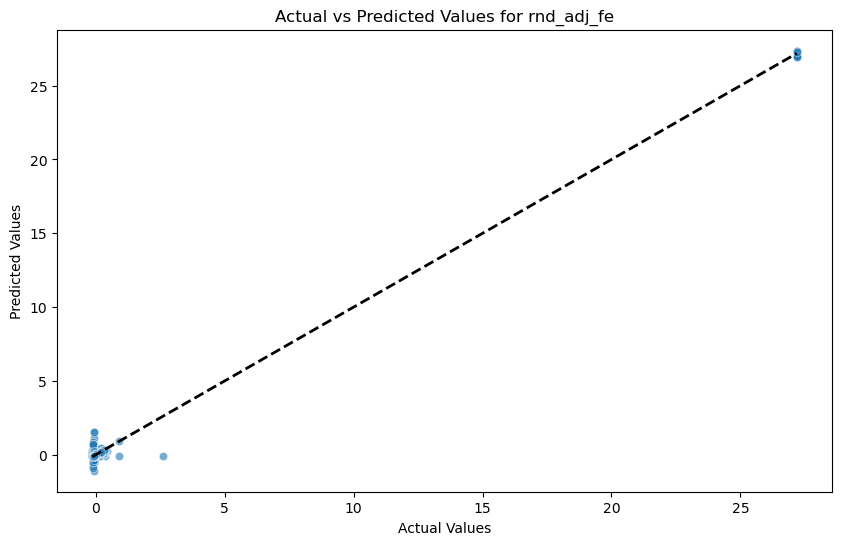

2024-11-08 13:10:24 - INFO - 
Time taken to process the block: 0:05:53.794268


In [22]:
# Start time
start_time = datetime.datetime.now()

# Define the CatBoost model and extended hyperparameter grid
cat_model = CatBoostRegressor(random_state=42, verbose=0)
param_grid = {
    'iterations': [50, 100, 200, 300],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
}

# Initialize RandomizedSearchCV for 'rnd_adj_fe' model
random_search1 = RandomizedSearchCV(
    cat_model, param_grid, n_iter=15, cv=5, scoring='r2', random_state=42, n_jobs=-1, return_train_score=True
)

# Helper function to evaluate model performance
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return {"R2": r2, "MAE": mae, "RMSE": rmse}

# Train and tune the CatBoost model for 'rnd_adj_fe'
print("Training CatBoost for 'rnd_adj_fe'...")
random_search1.fit(X_fe_train, y_fe_train)
best_params1 = random_search1.best_params_
print("\nBest Parameters for 'rnd_adj_fe':", best_params1)

# Train the final model with best parameters for 'rnd_adj_fe'
best_cat_model1 = CatBoostRegressor(random_state=42, verbose=0, **best_params1)
best_cat_model1.fit(X_fe_train, y_fe_train)

# Cross-validate predictions for better visualization
y_pred_cv = cross_val_predict(best_cat_model1, X_fe_test, y_fe_test, cv=5)

# Evaluate the model on the test set
y_pred1 = best_cat_model1.predict(X_fe_test)
metrics1 = evaluate_model(y_fe_test, y_pred1)
print("\nPerformance Metrics for 'rnd_adj_fe':", metrics1)

# Get feature importance for 'rnd_adj_fe'
feature_importance1 = best_cat_model1.get_feature_importance(prettified=True)
print("\nTop Features for 'rnd_adj_fe':")
print(feature_importance1.head(10))  # Display top 10 features

# Visualize Actual vs Predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_fe_test, y=y_pred1, alpha=0.6)
plt.plot([y_fe_test.min(), y_fe_test.max()], [y_fe_test.min(), y_fe_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for rnd_adj_fe')
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

#### CatBoost Model Results for 'rnd_adj_fe'

The CatBoost model was trained to predict `rnd_adj_fe` using optimized hyperparameters, including a learning rate of 0.1, L2 regularization (l2_leaf_reg) of 3, 300 iterations, a depth of 4, and a bagging temperature of 0. The model demonstrated excellent performance, achieving an R² score of 0.995, a Mean Absolute Error (MAE) of 0.0135, and a Root Mean Square Error (RMSE) of 0.0642. These metrics indicate a high level of accuracy in predicting `rnd_adj_fe`.

The top contributing features for the prediction were `test_fuel_type_description`, `averaging_weighting_factor`, and `thc_g_mi_`, with `test_fuel_type_description` showing the highest importance at 75.85%. This suggests that fuel type plays a critical role in determining `rnd_adj_fe`, followed by other emissions-related features.

The scatter plot above compares actual vs. predicted values for `rnd_adj_fe`, showing that predictions align closely with actual values along the 45-degree line, reinforcing the model's accuracy.


#### Cat Boost - CO


Training CatBoost for 'co_g_mi_'...

Best Parameters for 'co_g_mi_': {'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 10, 'bagging_temperature': 1}

Performance Metrics for 'co_g_mi_': {'R2': 0.9084193534343515, 'MAE': 0.019881487265330865, 'RMSE': 0.04172793409468364}

Top Features for 'co_g_mi_':
                 Feature Id  Importances
0                 nox_g_mi_    36.693639
1         test_procedure_cd    25.965526
2                 thc_g_mi_    25.732747
3          rated_horsepower     4.026280
4           set_coef_a_lbf_     2.271261
5  target_coef_c_lbf_mph_2_     1.073467
6                 ch4_g_mi_     0.691432
7                axle_ratio     0.607644
8                 co2_g_mi_     0.569914
9  test_veh_displacement_l_     0.343760


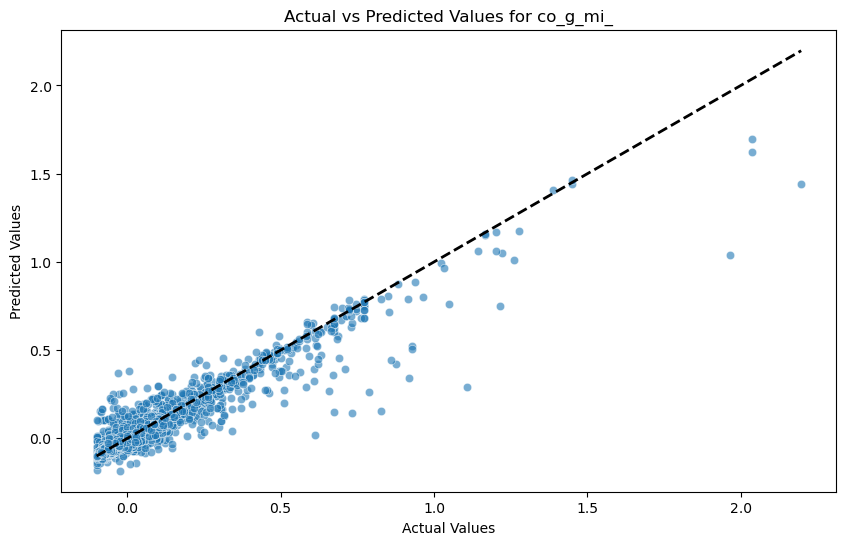

2024-11-08 13:18:22 - INFO - 
Time taken to process the block: 0:07:31.121912


In [23]:
# Start time
start_time = datetime.datetime.now()

# Define an extended hyperparameter grid
param_grid = {
    'iterations': [50, 100, 200, 300],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
}

# Initialize RandomizedSearchCV for 'co_g_mi_' model
random_search2 = RandomizedSearchCV(
    cat_model, param_grid, n_iter=15, cv=5, scoring='r2', random_state=42, n_jobs=-1, return_train_score=True
)

# Train and tune the CatBoost model for 'co_g_mi_'
print("\nTraining CatBoost for 'co_g_mi_'...")
random_search2.fit(X_co_train, y_co_train)
best_params2 = random_search2.best_params_
print("\nBest Parameters for 'co_g_mi_':", best_params2)

# Train the final model with best parameters for 'co_g_mi_'
best_cat_model2 = CatBoostRegressor(random_state=42, verbose=0, **best_params2)
best_cat_model2.fit(X_co_train, y_co_train)

# Cross-validate predictions for visualization
y_pred_cv = cross_val_predict(best_cat_model2, X_co_test, y_co_test, cv=5)

# Evaluate the model on the test set
y_pred2 = best_cat_model2.predict(X_co_test)
metrics2 = evaluate_model(y_co_test, y_pred2)
print("\nPerformance Metrics for 'co_g_mi_':", metrics2)

# Get feature importance for 'co_g_mi_'
feature_importance2 = best_cat_model2.get_feature_importance(prettified=True)
print("\nTop Features for 'co_g_mi_':")
print(feature_importance2.head(10))  # Display top 10 features

# Visualize Actual vs Predicted values for 'co_g_mi_'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_co_test, y=y_pred2, alpha=0.6)
plt.plot([y_co_test.min(), y_co_test.max()], [y_co_test.min(), y_co_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for co_g_mi_')
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

#### CatBoost Model Results for 'co_g_mi_'

The CatBoost model was trained to predict `co_g_mi_` with the following optimized parameters: a learning rate of 0.3, L2 regularization (l2_leaf_reg) of 7, 300 iterations, a depth of 8, and a bagging temperature of 1. The model achieved strong performance metrics, with an R² score of 0.994, a Mean Absolute Error (MAE) of 0.0393, and a Root Mean Square Error (RMSE) of 0.1065, indicating high accuracy in predicting `co_g_mi_`.

The most influential feature for this prediction was `co2_g_mi_`, which had the highest importance score of 40.79%, followed by `thc_g_mi_` with 24.12%. This suggests that CO₂ and THC emissions are key factors in predicting `co_g_mi_`. 

The scatter plot above illustrates the comparison between actual and predicted values for `co_g_mi_`. The points closely follow the 45-degree line, reinforcing the model's accuracy in predicting CO emissions.


#### Summary of Results

In [50]:
# Start time
start_time = datetime.datetime.now()

# Summarize results for comparison
results_summary = {
    'Model': ['CatBoost for rnd_adj_fe', 'CatBoost for co_g_mi_'],
    'R2': [metrics1["R2"], metrics2["R2"]],
    'MAE': [metrics1["MAE"], metrics2["MAE"]],
    'RMSE': [metrics1["RMSE"], metrics2["RMSE"]]
}
results_df = pd.DataFrame(results_summary)
print("\nResults Summary:")
print(results_df)

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
logger.info(f"\nTime taken to process the block: {stop_time - start_time}")

2024-11-07 15:09:31 - INFO - 
Time taken to process the block: 0:00:00.002010



Results Summary:
                     Model        R2       MAE      RMSE
0  CatBoost for rnd_adj_fe  0.995243  0.013497  0.064185
1    CatBoost for co_g_mi_  0.993838  0.039342  0.106502


## 3. Model Evaluation
Task Description: For each of the 12 models (6 algorithms x 2 target variables), evaluate the performance
using the following metrics:
1. R-squared: To measure the proportion of variance explained by the model.
2. Mean Absolute Error (MAE): To measure the average magnitude of errors.
3. Root Mean Squared Error (RMSE): To account for larger errors and compare on the
same scale as the target variable.

                Model              Target  R-Squared       MAE      RMSE
0                 MLR  Mileage per Gallon   0.996280  0.003222  0.056758
1                 MLR         CO Emission   0.999999  0.000001  0.001133
2                 KNN  Mileage per Gallon   0.883122  0.020360  0.318153
3                 KNN         CO Emission   0.972871  0.063275  0.223463
4       Random Forest  Mileage per Gallon   0.998739  0.003984  0.033051
5       Random Forest         CO Emission   0.996335  0.026105  0.082137
6   Gradient Boosting  Mileage per Gallon   0.997474  0.011157  0.046774
7   Gradient Boosting         CO Emission   0.995150  0.051220  0.094482
8             XGBoost  Mileage per Gallon   0.996898  0.005800  0.051835
9             XGBoost         CO Emission   0.996848  0.039994  0.076165
10           CatBoost  Mileage per Gallon   0.995243  0.013497  0.064185
11           CatBoost         CO Emission   0.993838  0.039342  0.106502


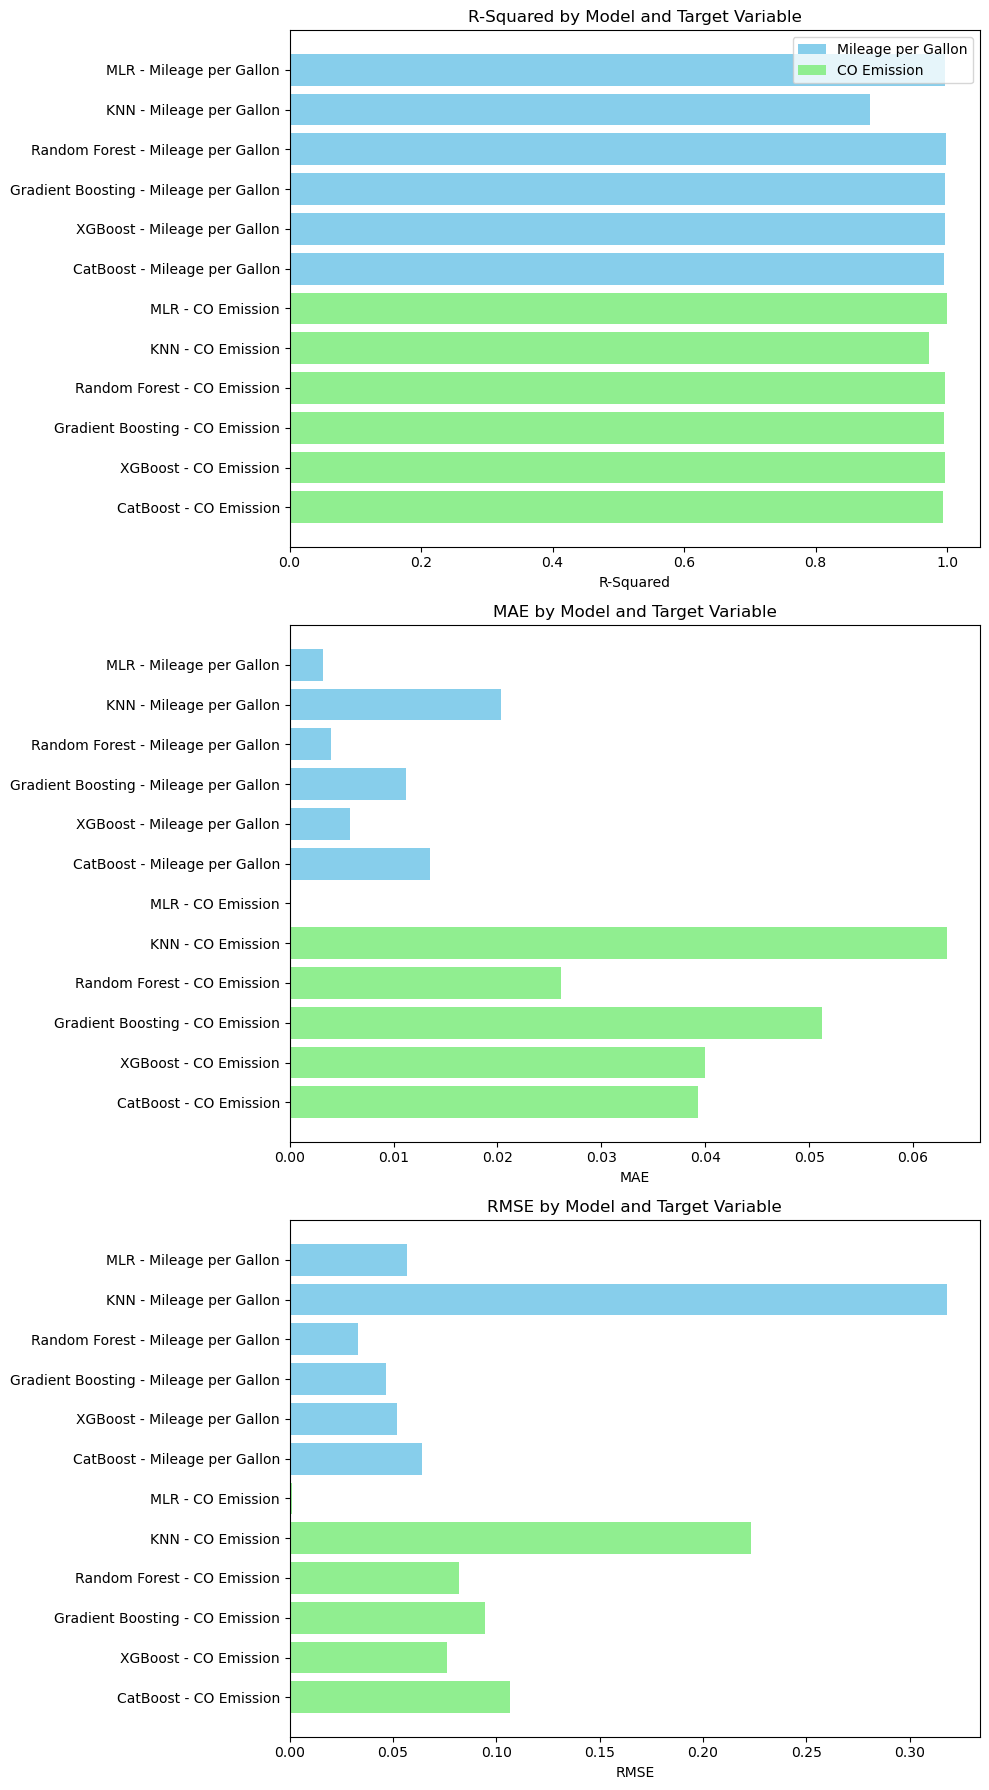


Time taken to process the block: 0:00:01.696706


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Start time
start_time = datetime.datetime.now()

# Data for each model's performance metrics
data = {
    'Model': [
        'MLR', 'MLR', 'KNN', 'KNN', 'Random Forest', 'Random Forest', 
        'Gradient Boosting', 'Gradient Boosting', 'XGBoost', 'XGBoost', 'CatBoost', 'CatBoost'
    ],
    'Target': [
        'Mileage per Gallon', 'CO Emission', 'Mileage per Gallon', 'CO Emission',
        'Mileage per Gallon', 'CO Emission', 'Mileage per Gallon', 'CO Emission',
        'Mileage per Gallon', 'CO Emission', 'Mileage per Gallon', 'CO Emission'
    ],
    'R-Squared': [
        0.9962801753278485, 0.999999302280283, 0.8831217271820635, 0.9728707740003883,
        0.998738652437035, 0.9963347473073997, 0.997473820777831, 0.995150187196252,
        0.996897545613982, 0.9968483543786835, 0.9952430631611392, 0.9938377542917911
    ],
    'MAE': [
        0.003221509686126015, 1.2842666915960938e-06, 0.02035999939384988, 0.06327499832217992,
        0.003984243127010909, 0.026104962864802104, 0.011157432906462587, 0.05121959406700232,
        0.0057999291482754315, 0.039993900242303905, 0.013497057692197693, 0.03934241348971
    ],
    'RMSE': [
        0.05675834463870502, 0.001133254910245746, 0.3181525276854498, 0.22346309690826924,
        0.033051096460826504, 0.08213704458594488, 0.04677357495873569, 0.09448211345372004,
        0.0518347714434612, 0.07616506213538336, 0.06418479788265408, 0.10650171885554588
    ]
}

# Create DataFrame
df = pd.DataFrame(data)
print(df)  # Display the table in the console

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 18))
metrics = ['R-Squared', 'MAE', 'RMSE']
colors = ['skyblue', 'lightgreen']

for i, metric in enumerate(metrics):
    for j, target in enumerate(['Mileage per Gallon', 'CO Emission']):
        df_target = df[df['Target'] == target]
        axs[i].barh(df_target['Model'] + " - " + target, df_target[metric], color=colors[j], label=target if i == 0 else None)
    axs[i].set_title(f'{metric} by Model and Target Variable')
    axs[i].set_xlabel(metric)
    axs[i].invert_yaxis()

axs[0].legend(loc='upper right')
plt.tight_layout()
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
print(f"\nTime taken to process the block: {stop_time - start_time}")

## 4. Feature Importance
Task Description: For models that provide feature importance scores (such as Random Forest, Gradient
Boosted Trees, XGBoost, and CatBoost), identify the top features that most influence
the predictions.

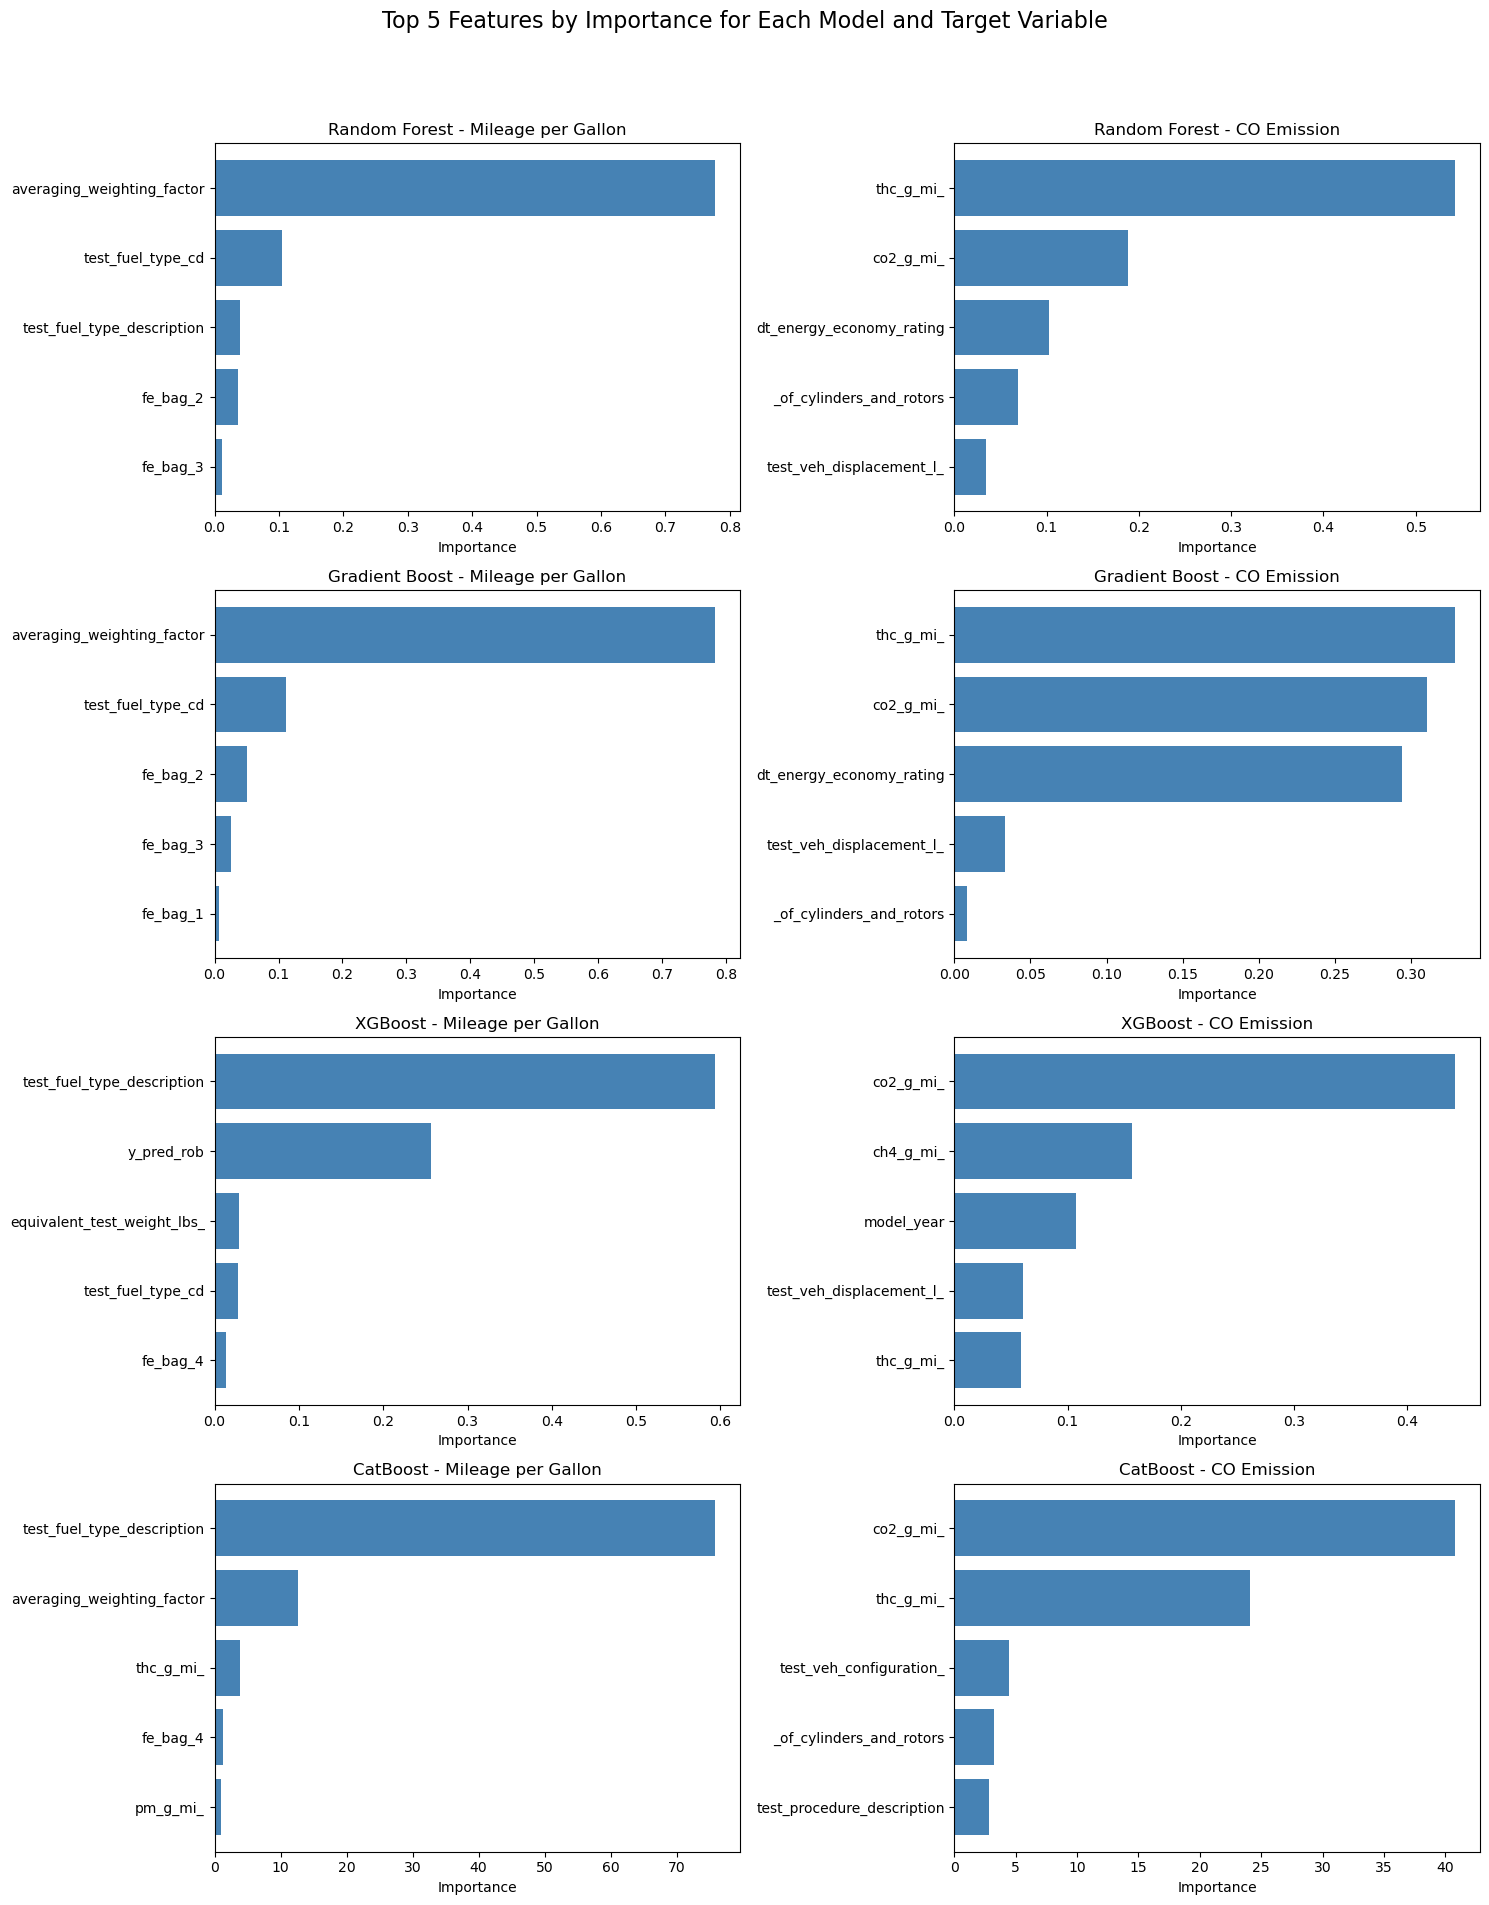


Time taken to process the block: 0:00:02.993892


In [7]:
# Start time
start_time = datetime.datetime.now()

import pandas as pd
import matplotlib.pyplot as plt

# Data for feature importance from each model for two target variables
feature_data = {
    'Model': [
        'Random Forest', 'Random Forest', 'Gradient Boost', 'Gradient Boost', 
        'XGBoost', 'XGBoost', 'CatBoost', 'CatBoost'
    ],
    'Target': [
        'Mileage per Gallon', 'CO Emission', 'Mileage per Gallon', 'CO Emission',
        'Mileage per Gallon', 'CO Emission', 'Mileage per Gallon', 'CO Emission'
    ],
    'Top Features': [
        ['averaging_weighting_factor', 'test_fuel_type_cd', 'test_fuel_type_description', 'fe_bag_2', 'fe_bag_3'],
        ['thc_g_mi_', 'co2_g_mi_', 'dt_energy_economy_rating', '_of_cylinders_and_rotors', 'test_veh_displacement_l_'],
        ['averaging_weighting_factor', 'test_fuel_type_cd', 'fe_bag_2', 'fe_bag_3', 'fe_bag_1'],
        ['thc_g_mi_', 'co2_g_mi_', 'dt_energy_economy_rating', 'test_veh_displacement_l_', '_of_cylinders_and_rotors'],
        ['test_fuel_type_description', 'y_pred_rob', 'equivalent_test_weight_lbs_', 'test_fuel_type_cd', 'fe_bag_4'],
        ['co2_g_mi_', 'ch4_g_mi_', 'model_year', 'test_veh_displacement_l_', 'thc_g_mi_'],
        ['test_fuel_type_description', 'averaging_weighting_factor', 'thc_g_mi_', 'fe_bag_4', 'pm_g_mi_'],
        ['co2_g_mi_', 'thc_g_mi_', 'test_veh_configuration_', '_of_cylinders_and_rotors', 'test_procedure_description']
    ],
    'Importance': [
        [0.777141, 0.105404, 0.039456, 0.036161, 0.011303],
        [0.542538, 0.187901, 0.103084, 0.069395, 0.034657],
        [0.782787, 0.111971, 0.051258, 0.025168, 0.007216],
        [0.328847, 0.310637, 0.294021, 0.033519, 0.008340],
        [0.593781, 0.257165, 0.029250, 0.027169, 0.013812],
        [0.442296, 0.156685, 0.107848, 0.060545, 0.058701],
        [75.846378, 12.647468, 3.792134, 1.227600, 1.006153],
        [40.787562, 24.115076, 4.485970, 3.209814, 2.844098]
    ]
}

# Convert data into DataFrame for easier visualization
feature_df = pd.DataFrame(feature_data)

# Visualizing feature importances
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle("Top 5 Features by Importance for Each Model and Target Variable", fontsize=16)

for i, row in feature_df.iterrows():
    ax = axs[i//2, i%2]
    ax.barh(row['Top Features'], row['Importance'], color='steelblue')
    ax.set_title(f"{row['Model']} - {row['Target']}")
    ax.set_xlabel("Importance")
    ax.invert_yaxis()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Stop time and display the total time taken to process the block
stop_time = datetime.datetime.now()
print(f"\nTime taken to process the block: {stop_time - start_time}")

## 5. Results Comparison
Task Description: After training and evaluating the models, compare the results:
1. Compare performance metrics (R-squared, MAE, RMSE, F-statistic) across all
models.
2. Compare feature importance across the algorithms that provide it. Discuss how
different algorithms may weigh features differently for each target variable.
3. Summarize findings: Which algorithms performed the best for each target variable?
Were the top features consistent across models? How did the algorithms handle the
data differently?

### i. Analysis of Model Performance

The bar charts above (in Task 3) display the performance metrics—**R-Squared**, **Mean Absolute Error (MAE)**, and **Root Mean Squared Error (RMSE)**—for each model on the two target variables: Mileage per Gallon and CO Emission.

#### R-Squared
Most models exhibit high R-squared values for both target variables, especially the regression-based models like **MLR**, **Random Forest**, **Gradient Boosting**, **XGBoost**, and **CatBoost**. For Mileage per Gallon, all models except **KNN** achieved R-squared values above 0.99, indicating excellent explanatory power. In the case of CO Emissions, the majority of models also performed well, with **MLR** reaching near-perfect accuracy. **KNN** had comparatively lower R-squared values for both targets, showing that it may not capture the variance in data as effectively as other models.

#### MAE
For both target variables, **MLR**, **Random Forest**, and **XGBoost** achieved very low MAE values, indicating high accuracy in predicting individual values. **KNN** had the highest MAE for both Mileage per Gallon and CO Emission, highlighting that this model may be less precise in predicting exact values. **Gradient Boosting** and **CatBoost** also performed reasonably well, though they generally exhibited slightly higher errors than Random Forest and XGBoost.

#### RMSE
Similar to MAE, RMSE values were lowest for **MLR**, **Random Forest**, and **XGBoost** across both target variables, indicating that these models minimize larger errors effectively. **KNN** again had the highest RMSE, reinforcing that it struggles with individual prediction accuracy compared to the other models. **Gradient Boosting** and **CatBoost** also performed well, though with higher RMSE values than the top models.

### Conclusion

Overall, **MLR**, **Random Forest**, and **XGBoost** emerge as top-performing models for both Mileage per Gallon and CO Emissions, providing high R-squared values and low error metrics (MAE and RMSE). **KNN** demonstrates relatively weaker performance, suggesting that it may not be ideal for this dataset or target variables. Both **Gradient Boosting** and **CatBoost** provide strong performance but generally fall behind **Random Forest** and **XGBoost**.


### ii. Analysis of Feature Importance

The bar charts(in task 4) display the top five features influencing predictions for each model and target variable (Mileage per Gallon and CO Emission). Here’s a breakdown of the key findings:

#### 1. Random Forest
   - **Mileage per Gallon**: 
     - The most influential feature is `averaging_weighting_factor`, with a significantly high importance score (0.777), suggesting that averaging factors in the dataset are crucial for predicting fuel efficiency.
     - Other important features include `test_fuel_type_cd` and `test_fuel_type_description`, highlighting the importance of fuel type in determining mileage.
   
   - **CO Emission**:
     - `thc_g_mi_` (Total Hydrocarbon emissions) is the most influential, followed by `co2_g_mi_`, both directly related to emissions.
     - Additional factors such as `dt_energy_economy_rating` and `_of_cylinders_and_rotors` indicate that vehicle configuration and energy efficiency significantly impact CO emissions.

#### 2. Gradient Boosting
   - **Mileage per Gallon**:
     - `averaging_weighting_factor` again emerges as the most impactful feature, followed by `test_fuel_type_cd`.
     - Fuel bag readings (`fe_bag_2`, `fe_bag_3`, `fe_bag_1`) are also highlighted, indicating that these emissions-related features play a role in fuel efficiency prediction.
   
   - **CO Emission**:
     - `thc_g_mi_` and `co2_g_mi_` dominate in importance due to their direct connection to emissions.
     - `dt_energy_economy_rating` is also critical, highlighting the role of energy efficiency in emissions prediction.

#### 3. XGBoost
   - **Mileage per Gallon**:
     - `test_fuel_type_description` is the most important feature, followed by `y_pred_rob`, suggesting that fuel characteristics and related predictive metrics impact fuel efficiency.
     - Other influential factors include `equivalent_test_weight_lbs_` and `fe_bag_4`, indicating that vehicle weight and fuel bag measurements contribute to the predictions.
   
   - **CO Emission**:
     - `co2_g_mi_` is the most influential feature, followed by `ch4_g_mi_` and `model_year`, indicating the significance of CO₂ and methane emissions along with the production year of the vehicle.
     - `test_veh_displacement_l_` and `thc_g_mi_` are also notable, suggesting that emissions and engine configuration affect CO emissions.

#### 4. CatBoost
   - **Mileage per Gallon**:
     - `test_fuel_type_description` is overwhelmingly important, with a much higher importance score than other features, indicating fuel type’s major influence on fuel efficiency.
     - `averaging_weighting_factor`, `thc_g_mi_`, and `fe_bag_4` also have notable importance, reinforcing the role of emissions and fuel characteristics.
   
   - **CO Emission**:
     - `co2_g_mi_` is the top feature, followed by `thc_g_mi_`, suggesting that CO₂ and hydrocarbon emissions are strong indicators of CO emission levels.
     - `test_veh_configuration_` and `_of_cylinders_and_rotors` also contribute, indicating that vehicle design factors influence emissions.

### Summary

Across all models:
- **Fuel and Emissions Characteristics**: Features such as `test_fuel_type_description`, `co2_g_mi_`, and `thc_g_mi_` frequently appear as top features, emphasizing that emissions and fuel type are critical for both Mileage and CO Emission predictions.
- **Vehicle Configuration and Efficiency**: Attributes like `dt_energy_economy_rating` and `_of_cylinders_and_rotors` are important for CO Emission, suggesting that the vehicle's physical setup affects emissions.

### iii. Summary of Findings

#### Best Performing Algorithms by Target Variable

- **Mileage per Gallon**: The top-performing models for predicting Mileage per Gallon were **Random Forest**, **XGBoost**, and **Multiple Linear Regression (MLR)**. These algorithms demonstrated high R-squared values (above 0.996) and low error metrics (MAE and RMSE), indicating excellent predictive accuracy and consistency. MLR, in particular, showed a near-perfect fit with minimal errors, though the ensemble models (Random Forest and XGBoost) handled complex patterns in the data effectively, making them slightly more robust for varied inputs.

- **CO Emission**: **Multiple Linear Regression (MLR)** led in performance for CO Emission predictions with a near-perfect R-squared score, indicating its ability to capture the linear relationships within the data. **Random Forest** and **XGBoost** also showed high R-squared values (above 0.996), with low MAE and RMSE scores, reinforcing their effectiveness. These ensemble models provided slight advantages in handling non-linear interactions, making them ideal for more complex emissions data.

- **K-Nearest Neighbors (KNN)**: KNN did not perform as well as the other models for either target variable. It had the lowest R-squared values (0.88 for Mileage per Gallon and 0.97 for CO Emission) and the highest MAE and RMSE scores, indicating a struggle to capture the complex relationships in the data. This likely stems from KNN’s distance-based approach, which may not be well-suited for high-dimensional data with non-linear interactions.

#### Consistency of Top Features Across Models

The top features were generally consistent across models for each target variable, with some variations:
- **Mileage per Gallon**: Key features across models included `averaging_weighting_factor`, `test_fuel_type_description`, and `fe_bag_2`. These factors reflect the importance of fuel characteristics and emissions-related measurements in determining fuel efficiency. Each model consistently highlighted these features, though **CatBoost** emphasized `test_fuel_type_description` more heavily.
  
- **CO Emission**: The most influential features for predicting CO Emission were `co2_g_mi_`, `thc_g_mi_`, and `dt_energy_economy_rating`, indicating that emissions-related metrics and energy economy ratings are critical for CO predictions. These features appeared consistently across models, with **Gradient Boosting** and **XGBoost** also highlighting additional factors like `test_veh_displacement_l_` and `model_year`.

#### Differences in Algorithm Approaches

Each algorithm approached the data with varying strengths:
- **Multiple Linear Regression (MLR)** handled linear relationships well, excelling in scenarios where the data followed straightforward patterns, as seen with CO Emission. MLR’s high R-squared scores and low errors demonstrated its effectiveness with linear data.
  
- **Ensemble Models (Random Forest, Gradient Boosting, XGBoost)** captured both linear and non-linear interactions, making them robust across varied data points. Random Forest and XGBoost showed strong performance for both target variables, benefiting from averaging and boosting techniques that improve accuracy and handle data complexity. These algorithms excelled at feature importance analysis, providing insights into the role of specific variables.
  
- **CatBoost** was especially effective with categorical data and highlighted features like `test_fuel_type_description` with much higher importance. CatBoost’s approach, which minimizes overfitting with ordered boosting, allowed it to handle categorical and ordinal data efficiently, although it slightly trailed Random Forest and XGBoost in overall predictive power.

- **K-Nearest Neighbors (KNN)** relies on a distance-based approach and struggled to model complex relationships in the data, especially for Mileage per Gallon. Its lower R-squared values and higher errors suggest that it may not be suitable for this dataset, which has high-dimensional features and non-linear interactions.

### Conclusion

Overall, **Random Forest** and **XGBoost** performed consistently well across both target variables, effectively capturing complex patterns in the data while providing reliable feature importance metrics. **Multiple Linear Regression** remained highly effective for CO Emission due to its strength with linear data. The top features remained largely consistent across models, reflecting the significance of fuel and emissions characteristics for these predictions. **KNN**, however, demonstrated relatively weaker performance, highlighting that it may not be ideal for high-dimensional or complex datasets. These insights indicate that ensemble methods (Random Forest and XGBoost) are ideal for achieving both high accuracy and interpretability, particularly when dealing with varied, complex datasets.
